<a target="_blank" href="https://colab.research.google.com/github/sky1ove/katlas/blob/main/nbs/tutorial_04_enrichment.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Kinase enrichment analysis

In this session, we will analyze the differential change of phosphorylation sites in phosphoproteomics dataset.

## Setup

In [2]:
!pip install git+https://github.com/sky1ove/katlas.git -q

In [1]:
!pip install statsmodels -q

In [44]:
# katlas
from katlas.core import *
from katlas.plot import plot_rank

# utils
import pandas as pd, numpy as np, seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce, partial
from tqdm import tqdm

# statistics
from scipy.stats import ttest_rel,ttest_ind
from statsmodels.stats.multitest import multipletests

# disable warning
import warnings
warnings.filterwarnings("ignore", message="converting a masked element to nan")

pd.set_option('display.precision', 15)

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

## Data

The phosphoproteomics dataset is from paper [Chemical Phosphoproteomics Sheds New Light on the Targets and Modes of Action of AKT Inhibitors](https://pubs.acs.org/doi/10.1021/acschembio.0c00872); five clinical AKT inhibitors are evaluated in this study.

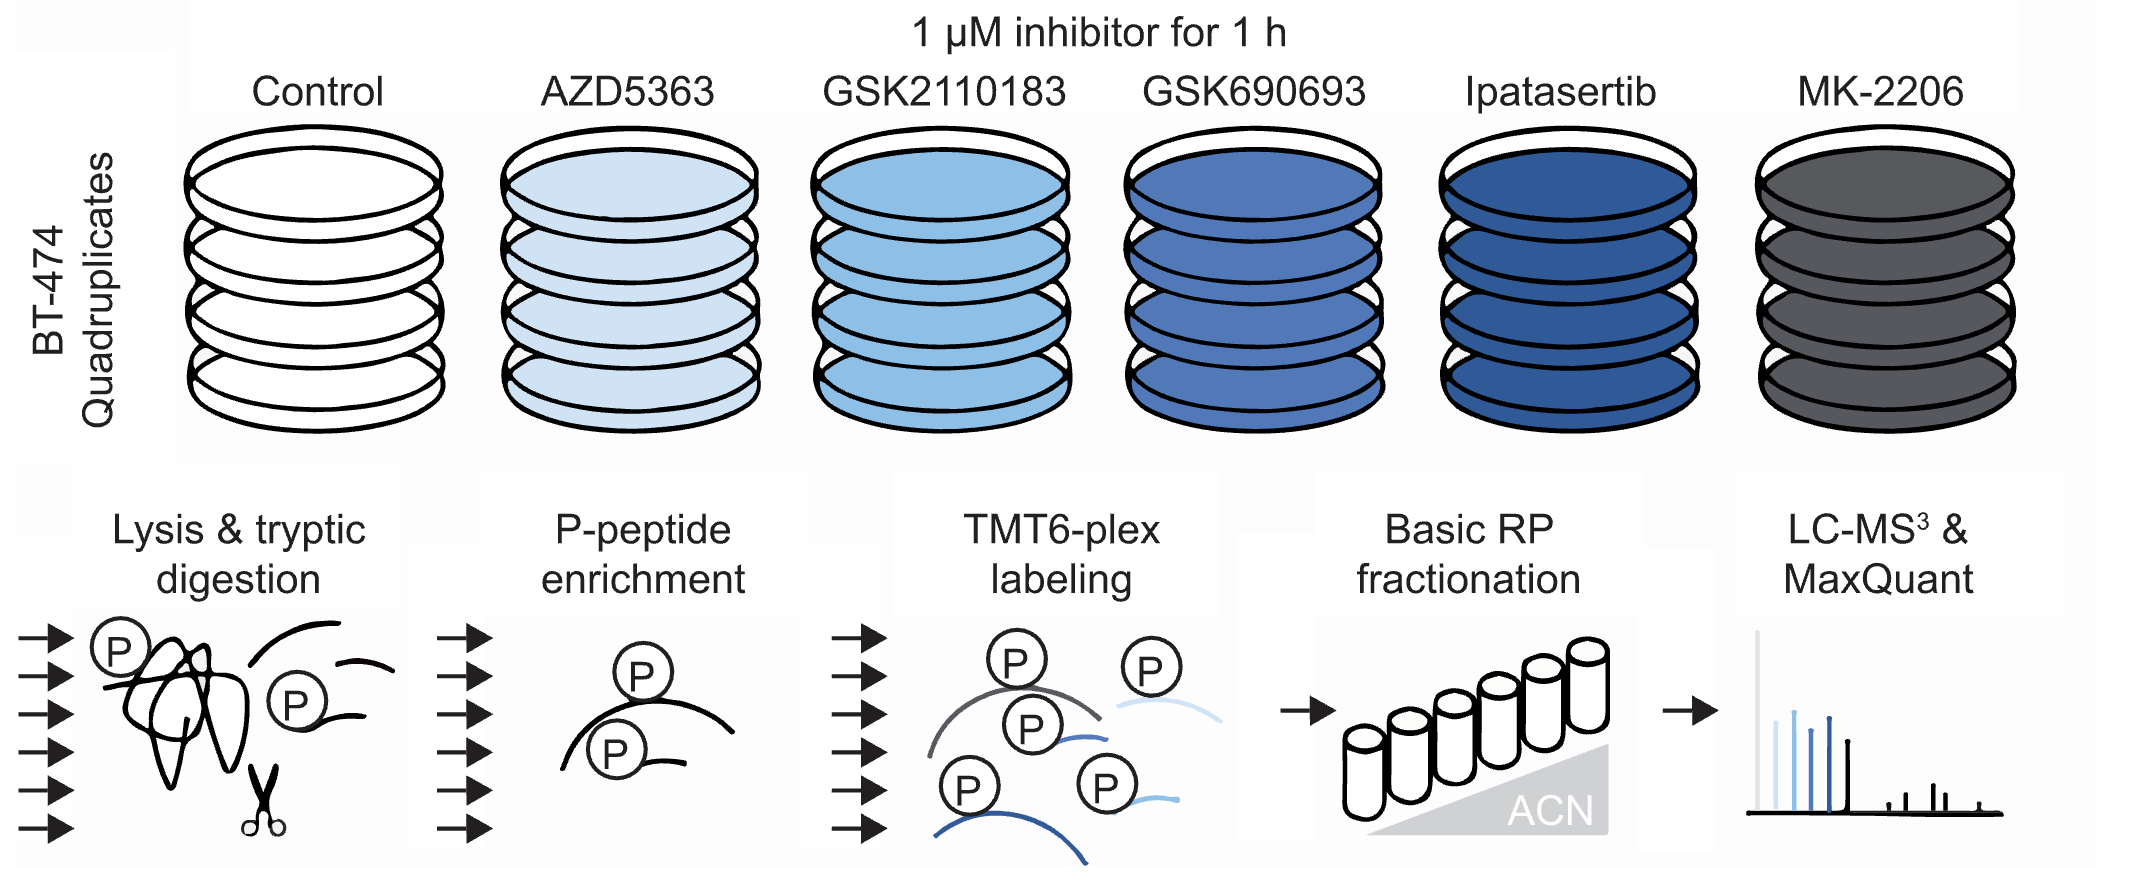

In [24]:
df = pd.read_csv('https://github.com/sky1ove/katlas/raw/main/nbs/raw/AKT_inhibitor.csv')

In [25]:
df.head()

,gene_site,site_seq,Control_R1,Control_R2,Control_R3,Control_R4,AZD5363_R1,AZD5363_R2,AZD5363_R3,AZD5363_R4,GSK2110183_R1,GSK2110183_R2,GSK2110183_R3,GSK2110183_R4,GSK690693_R1,GSK690693_R2,GSK690693_R3,GSK690693_R4,Ipatasertib_R1,Ipatasertib_R2,Ipatasertib_R3,Ipatasertib_R4,MK-2206_R1,MK-2206_R2,MK-2206_R3,MK-2206_R4
0,AAK1_S637,AGHRRILsDVtHsAV,14.167260000000001,13.791940000000000,13.888430000000000,13.991310000000000,14.581049999999999,14.802630000000001,14.723060000000000,14.857880000000000,14.713820000000000,14.413119999999999,14.362840000000000,14.710800000000001,14.858169999999999,14.523330000000000,14.47591,14.810269999999999,14.541550000000001,14.598560000000001,14.669480000000000,14.267690000000000,14.500560000000000,14.700110000000000,14.642170000000000,14.394790000000000
1,ABCF1_S105,MERLKKLsVPtsDEE,14.184260000000000,14.422390000000000,14.320520000000000,14.310689999999999,14.905970000000000,15.157950000000000,14.848050000000001,14.968950000000000,14.680930000000000,14.768760000000000,14.708550000000001,14.866390000000001,14.786070000000000,14.860379999999999,14.82788,14.924620000000001,14.888140000000000,15.019850000000000,14.857740000000000,14.809049999999999,14.915050000000001,14.815270000000000,15.067920000000001,14.526149999999999
2,ACIN1_S208,HSPRKSSsIsEEKGD,15.956730000000000,15.791060000000000,NaN,15.961280000000000,14.763690000000000,14.926340000000000,NaN,14.933990000000000,15.205380000000000,15.264620000000001,NaN,15.108590000000000,14.977750000000000,14.868259999999999,NaN,14.728800000000000,15.004510000000000,14.969420000000000,NaN,14.797020000000000,14.923180000000000,15.012650000000001,NaN,15.046220000000000
3,ACIN1_S216,IsEEKGDsDDEKPRK,17.457689999999999,16.997420000000002,17.373349999999999,17.434950000000001,16.252500000000001,16.341049999999999,16.316970000000001,16.411560000000001,16.706840000000000,16.672650000000001,16.749569999999999,16.590119999999999,16.460960000000000,16.370940000000001,16.38372,16.193570000000001,16.486070000000002,16.445869999999999,16.275169999999999,16.242329999999999,16.405529999999999,16.500750000000000,16.558160000000001,16.533030000000000
4,ACIN1_S240,QARAAkLsEGsQPAE,13.211040000000001,13.129730000000000,13.565530000000001,13.572440000000000,12.127129999999999,12.011320000000000,12.125540000000001,11.806080000000000,12.349919999999999,12.294269999999999,12.117860000000000,12.713939999999999,12.116260000000000,12.040110000000000,12.09775,12.322410000000000,11.838360000000000,12.090270000000000,12.027799999999999,11.561370000000000,12.093400000000001,12.152469999999999,12.159110000000000,11.888489999999999


In [26]:
df.columns

Index(['gene_site', 'site_seq', 'Control_R1', 'Control_R2', 'Control_R3',
       'Control_R4', 'AZD5363_R1', 'AZD5363_R2', 'AZD5363_R3', 'AZD5363_R4',
       'GSK2110183_R1', 'GSK2110183_R2', 'GSK2110183_R3', 'GSK2110183_R4',
       'GSK690693_R1', 'GSK690693_R2', 'GSK690693_R3', 'GSK690693_R4',
       'Ipatasertib_R1', 'Ipatasertib_R2', 'Ipatasertib_R3', 'Ipatasertib_R4',
       'MK-2206_R1', 'MK-2206_R2', 'MK-2206_R3', 'MK-2206_R4'],
      dtype='object')

In [27]:
ctrl = df.columns[df.columns.str.contains('Control')]

# below are five AKT inhibitors
AZD = df.columns[df.columns.str.contains('AZD5363')]
GSK2 = df.columns[df.columns.str.contains('GSK2110183')]
GSK6 = df.columns[df.columns.str.contains('GSK690693')] 
ipa = df.columns[df.columns.str.contains('Ipatasertib')]
MK = df.columns[df.columns.str.contains('MK')]

## T-test

As the data has already been log2 transformed, when calculating log2FC, we use substraction.

In [28]:
def get_ttest(df, 
              columns1, # list of column names for group1
              columns2, # list of column names for group2
              FC_method = 'median', # or mean
              paired=False, # whether or not it is paired ttest
              alpha=0.05, # significance level in multipletests for p_adj
              correction_method='fdr_bh', # method in multipletests for p_adj
             ):
    """
    Performs t-tests and calculates log2 fold change between two groups of columns in a DataFrame.
    NaN p-values are excluded from the multiple testing correction.

    Returns:
    DataFrame: Results including log2FC, p-values, adjusted p-values, significance, signed log10 P value, and signed log10 Padj
    """
    group1 = df[columns1]
    group2 = df[columns2]

    # Compute median values for each gene in both groups
    if FC_method == "median":
        m1 = group1.median(axis=1)
        m2 = group2.median(axis=1)
    elif FC_method == "mean":
        m1 = group1.mean(axis=1)
        m2 = group2.mean(axis=1)

    # As phosphoproteomics data has already been log transformed, we can directly use subtraction
    FCs = m2 - m1

    # Perform t-tests and handle NaN p-values    
    if paired:
        t_results = [ttest_rel(group1.loc[idx], group2.loc[idx], nan_policy='omit') for idx in tqdm(df.index, desc="Computing t-tests")]
    else:
        t_results = [ttest_ind(group1.loc[idx], group2.loc[idx], nan_policy='omit') for idx in tqdm(df.index, desc="Computing t-tests")]

    # Exclude NaN p-values before multiple testing correction
    p_values = [result.pvalue if result.pvalue is not np.nan else np.nan for result in t_results]
    valid_p_values = np.array(p_values, dtype=float)  # Ensure the correct data type

    # valid_p_values = np.array(p_values)
    valid_p_values = valid_p_values[~np.isnan(valid_p_values)]
    
    # Adjust for multiple testing on valid p-values only
    reject, pvals_corrected, _, _ = multipletests(valid_p_values, alpha=alpha, method=correction_method)
    
    # Create a full list of corrected p-values including NaNs
    full_pvals_corrected = np.empty_like(p_values)
    full_pvals_corrected[:] = np.nan
    np.place(full_pvals_corrected, ~np.isnan(p_values), pvals_corrected)
    
    # Adjust the significance accordingly
    full_reject = np.zeros_like(p_values, dtype=bool)
    np.place(full_reject, ~np.isnan(p_values), reject)

    # Create DataFrame with results
    results = pd.DataFrame({
        'log2FC': FCs,
        'p_value': p_values,
        'p_adj': full_pvals_corrected,
        'significant': full_reject
    })

    results['p_value'] = results['p_value'].astype(float)
    
    def get_signed_logP(r,p_col):
        log10 = -np.log10(r[p_col])
        return -log10 if r['log2FC']<0 else log10
    
    results['signed_logP'] = results.apply(partial(get_signed_logP,p_col='p_value'),axis=1)
    results['signed_logPadj'] = results.apply(partial(get_signed_logP,p_col='p_adj'),axis=1)
    
    return results

Let's use AZD for example:

In [29]:
azd = get_ttest(df,ctrl, AZD)

Computing t-tests: 100%|██████████| 10900/10900 [00:03<00:00, 3080.29it/s]


In [30]:
info = df.iloc[:,:2]

In [31]:
azd = pd.concat([info,azd],axis=1)

In [32]:
azd.sort_values('signed_logP')

,gene_site,site_seq,log2FC,p_value,p_adj,significant,signed_logP,signed_logPadj
152,MEPCE_S152,GGGkRRNsCNVGGGG,-2.501130000000000,0.000000003725373,0.000020303283625,True,-8.428830220767583,-4.692433718490942
282,ZBTB21_S411,PHRLRsFsAsQStDR,-1.058145000000000,0.000000021195787,0.000077011358788,True,-7.673750457074995,-4.113445213854034
258,SYNRG_S1075,GSHkRsLsLGDKEIs,-1.755589999999998,0.000000142382598,0.000387992579963,True,-6.846543086461211,-3.411176579848550
228,RBM14_S618,LsDyrRLsEsQLsFR,-1.419820000000001,0.000000823835017,0.001282828812526,True,-6.084159752241660,-2.891831294315293
81,EDC3_S131,KsQDVAVsPQQQQCs,-0.681769999999998,0.000001416070656,0.001481904192858,True,-5.848915076580682,-2.829179873184061
...,...,...,...,...,...,...,...,...
158,MRGBP_S191,DkVLtANsNPssPsA,1.841170000000000,0.000003460496478,0.002317484867381,True,5.460861588432619,2.634983093012703
56,CEP170B_S969,VSLRSGKsGPsPTtP,0.851699999999999,0.000001201825941,0.001481904192858,True,5.920158426163190,2.829179873184061
126,HEATR6_S643,LEETsVssPKGSSEP,1.443809999999999,0.000000403772190,0.000733519478986,True,6.393863596312025,3.134588348755045
159,MRGBP_S194,LtANsNPssPsAAkR,1.646900000000000,0.000000283021826,0.000616987581264,True,6.548180070969473,3.209723577364868


## Dataset processing

There are NaNs in site_seq, we will drop them

In [33]:
azd=azd.dropna(subset='site_seq')

Some site_seq contains multiple sequences splitted by ";", we will take the first one.

In [34]:
azd['site_seq2'] = azd.site_seq.str.split(';').str[0]

Make sure site sequence length are all consistent

In [35]:
azd['len'] = azd.site_seq2.str.len()

In [36]:
azd.len.value_counts() 

15    10541
Name: len, dtype: int64

In [37]:
azd['acceptor'] = azd.site_seq2.str[7]

## Substrate scoring

In [38]:
pspa_out = predict_kinase_df(azd,seq_col='site_seq2', **param_PSPA)
cddm_out = predict_kinase_df(azd,seq_col='site_seq2', **param_CDDM)

input dataframe has a length 10541
Preprocessing
Finish preprocessing
Calculating position: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]


100%|██████████| 396/396 [00:15<00:00, 25.54it/s]


input dataframe has a length 10541
Preprocessing
Finish preprocessing
Calculating position: [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 289/289 [00:05<00:00, 52.64it/s]


## Kinase enrichment

In [39]:
def top_kinases(site_row,top_n=5):
    # Sort the row in descending order and get the top n kinases
    top_kinases = site_row.sort_values(ascending=False).head(top_n)
    
    # Get the counts of the top kinases
    kinase_counts = top_kinases.index.value_counts()
    
    return kinase_counts

def get_result(site,p_col, site_score,is_Y=True,top_n = 5,p_threshold=1.3):
    
    if is_Y:
        idx_up = site.index[(site.acceptor.str.upper()=="Y") & (site[p_col]>= p_threshold)]
        idx_dn = site.index[(site.acceptor.str.upper()=="Y") & (site[p_col]<= -p_threshold)]
    else:
        idx_up = site.index[(site.acceptor.str.upper()!="Y") & (site[p_col]>= p_threshold)]
        idx_dn = site.index[(site.acceptor.str.upper()!="Y") & (site[p_col]<= -p_threshold)]
    
    up_site = site.loc[idx_up]
    dn_site = site.loc[idx_dn]

    up_score = site_score.loc[idx_up]
    dn_score = site_score.loc[idx_dn]
    
    func = partial(top_kinases,top_n=top_n)
    
    up_cnt = up_score.apply(func,axis=1)
    dn_cnt = dn_score.apply(func,axis=1)
    
    df_up_cnt = up_cnt.sum().reset_index(name = 'up_cnt')
    df_dn_cnt = dn_cnt.sum().reset_index(name = 'dn_cnt')
    
    df_w_up = up_cnt.multiply(abs(up_site[p_col]),axis=0).sum().reset_index(name = 'up_weighted_cnt')
    df_w_dn = dn_cnt.multiply(abs(dn_site[p_col]),axis=0).sum().reset_index(name = 'dn_weighted_cnt')
    
    dfs = [df_up_cnt,df_dn_cnt,df_w_up,df_w_dn]
    
    result = reduce(lambda left, right: pd.merge(left, right, how='outer'), dfs)
    
    result = result.fillna(0)
    result['enrich'] = result.apply(lambda r: r.up_weighted_cnt if r.up_weighted_cnt >= r.dn_weighted_cnt else -r.dn_weighted_cnt,axis=1)
    result['delta'] = result.up_weighted_cnt - result.dn_weighted_cnt
    result = result.rename(columns={'index':'kinase'})
    
    return result

In [40]:
st_cddm = get_result(azd,'signed_logPadj',cddm_out,is_Y=False,top_n=10)
st_pspa = get_result(azd,'signed_logPadj',pspa_out,is_Y=False,top_n=10)

In [42]:
st_cddm.sort_values('delta')

,kinase,up_cnt,dn_cnt,up_weighted_cnt,dn_weighted_cnt,enrich,delta
1,AKT1,16.0,97.0,28.014637687450698,193.761669272405697,-193.761669272405697,-165.747031584955010
105,P90RSK,32.0,109.0,58.098473889503012,212.249246788316384,-212.249246788316384,-154.150772898813386
3,AKT3,12.0,86.0,21.208488478746148,174.789354616435332,-174.789354616435332,-153.580866137689185
137,SGK1,11.0,77.0,19.167633111311090,153.062103765423331,-153.062103765423331,-133.894470654112240
2,AKT2,1.0,59.0,1.488649929392079,120.636086963556124,-120.636086963556124,-119.147437034164042
...,...,...,...,...,...,...,...
24,CDK2,79.0,42.0,134.684374307262971,79.714065821588065,134.684374307262971,54.970308485674906
57,GSK3B,34.0,4.0,65.092287561809968,7.255916941274301,65.092287561809968,57.836370620535668
26,CDK4,90.0,48.0,154.775681051118625,91.791473951369142,154.775681051118625,62.984207099749483
48,ERK2,93.0,46.0,159.173581583534769,86.679903384607471,159.173581583534769,72.493678198927299


### Enrich

"enrich" is the bigger value among up_weighted_cnt and dn_weighted_cnt

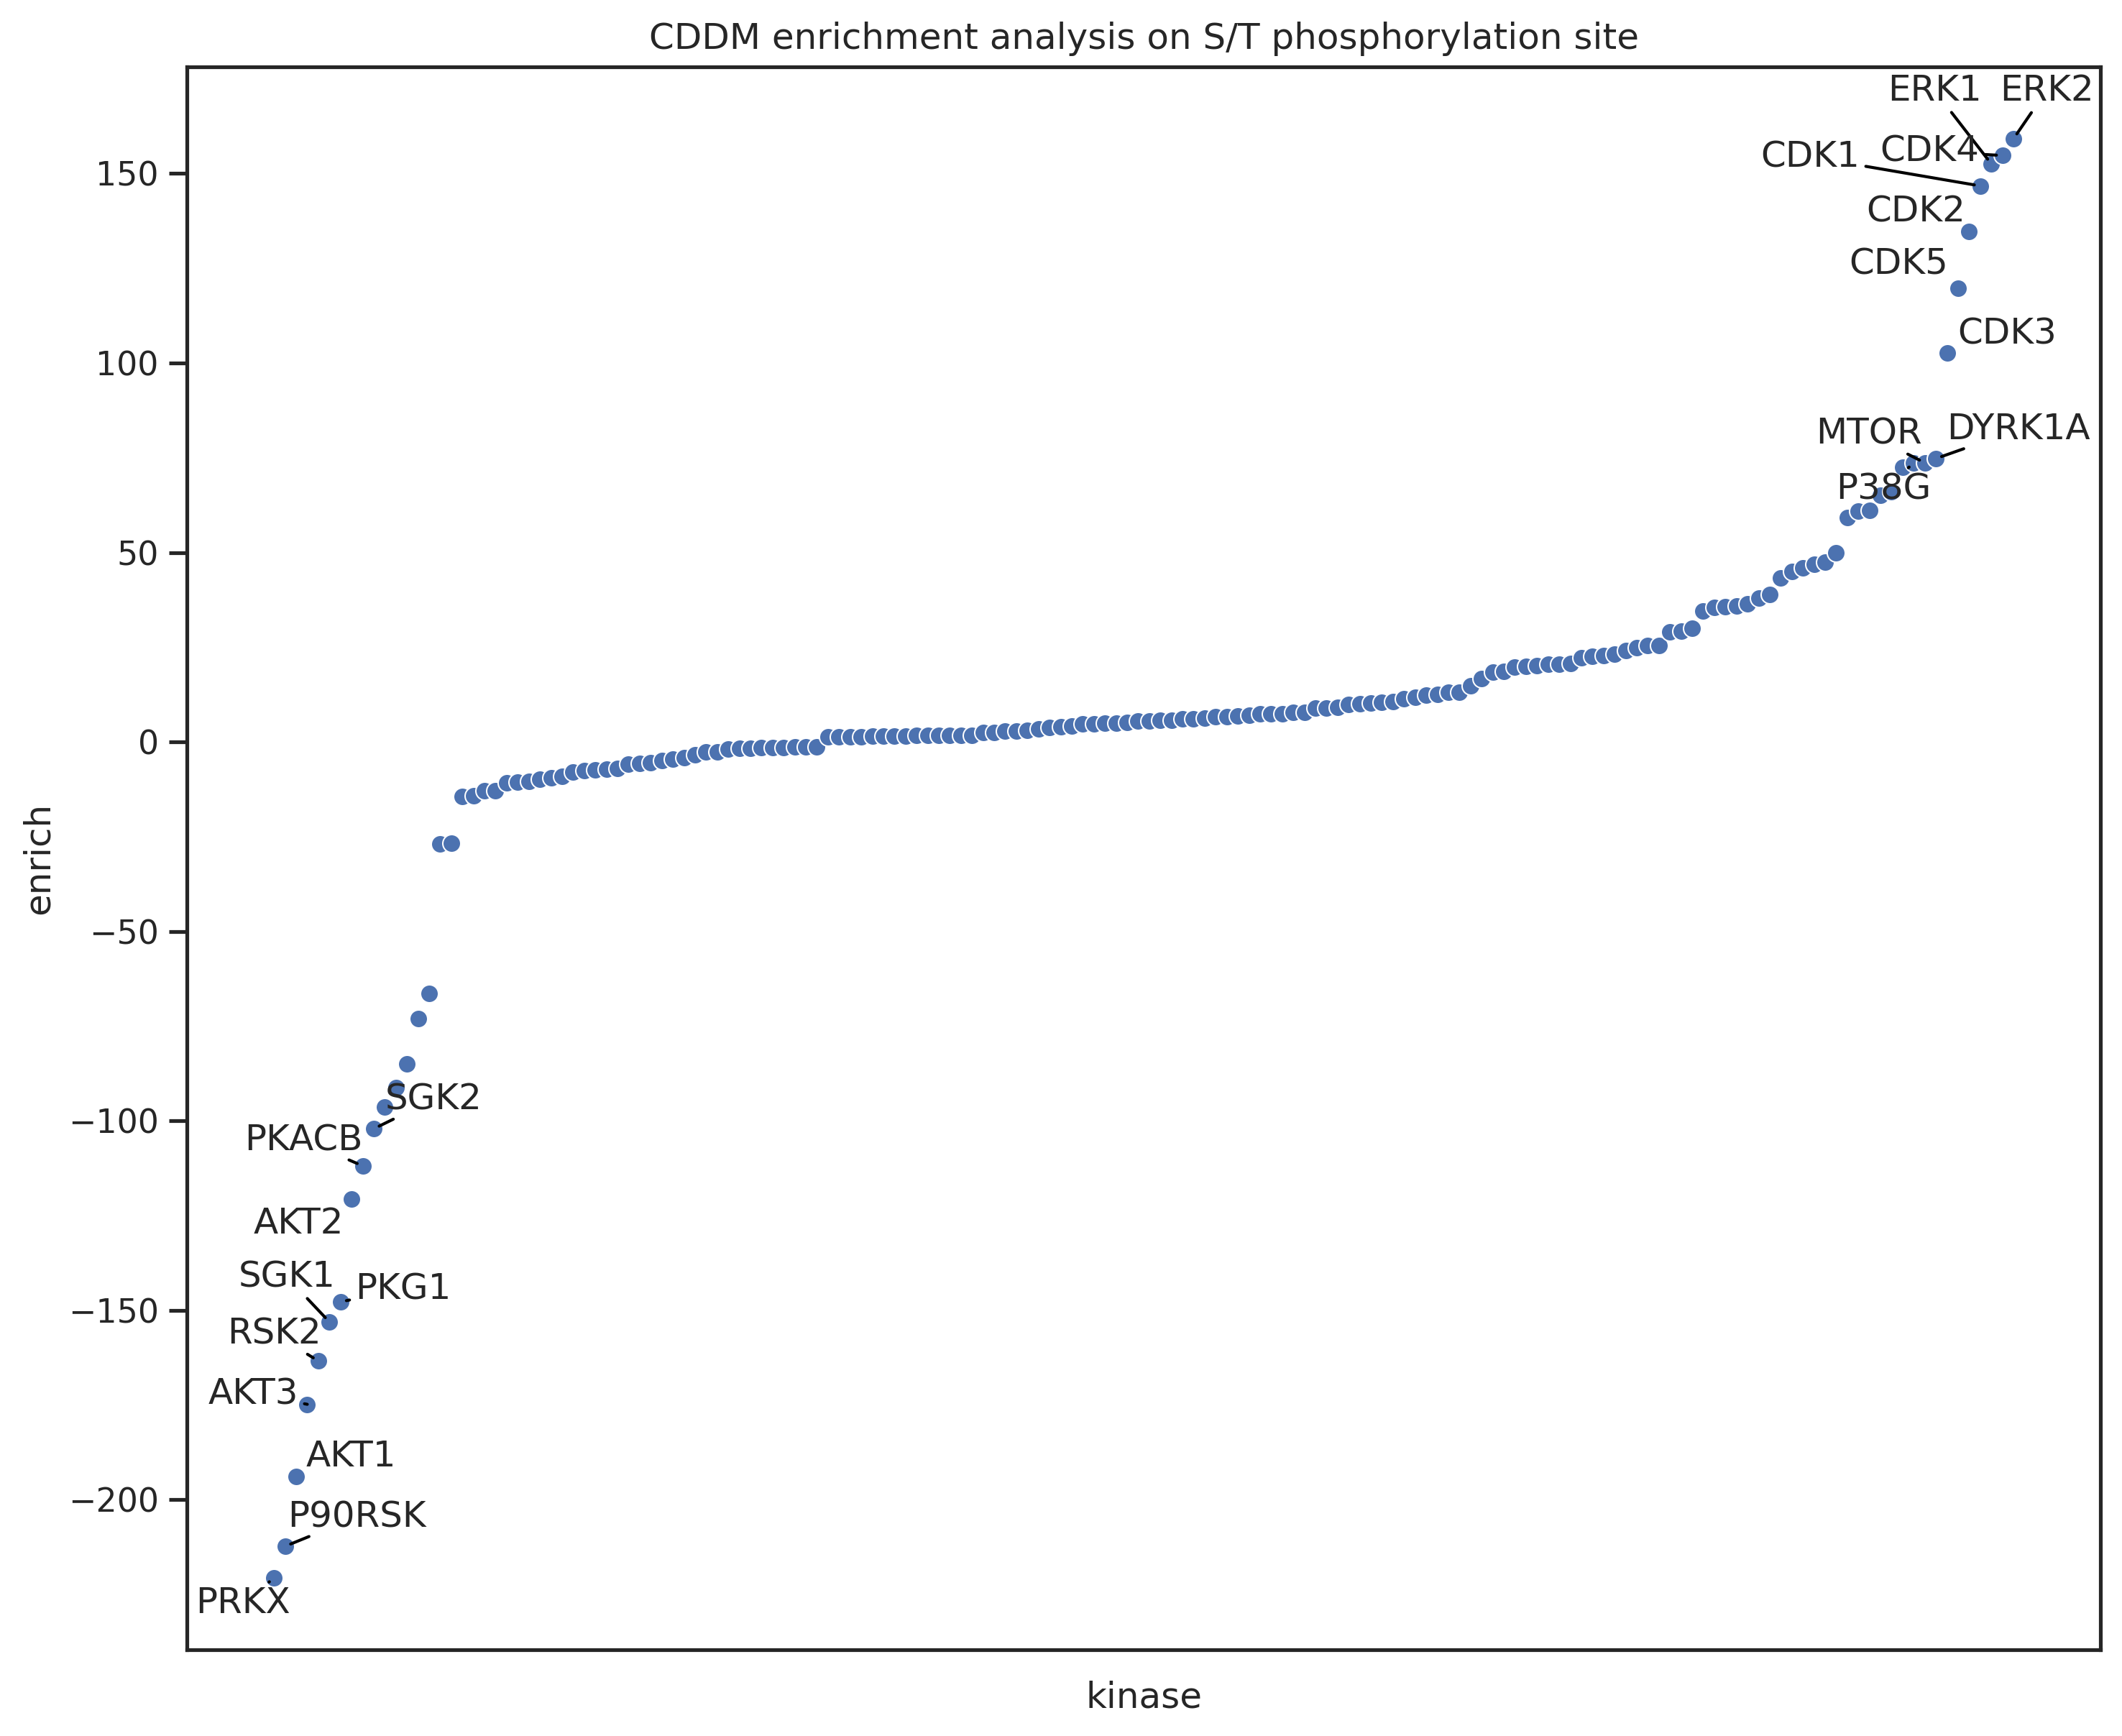

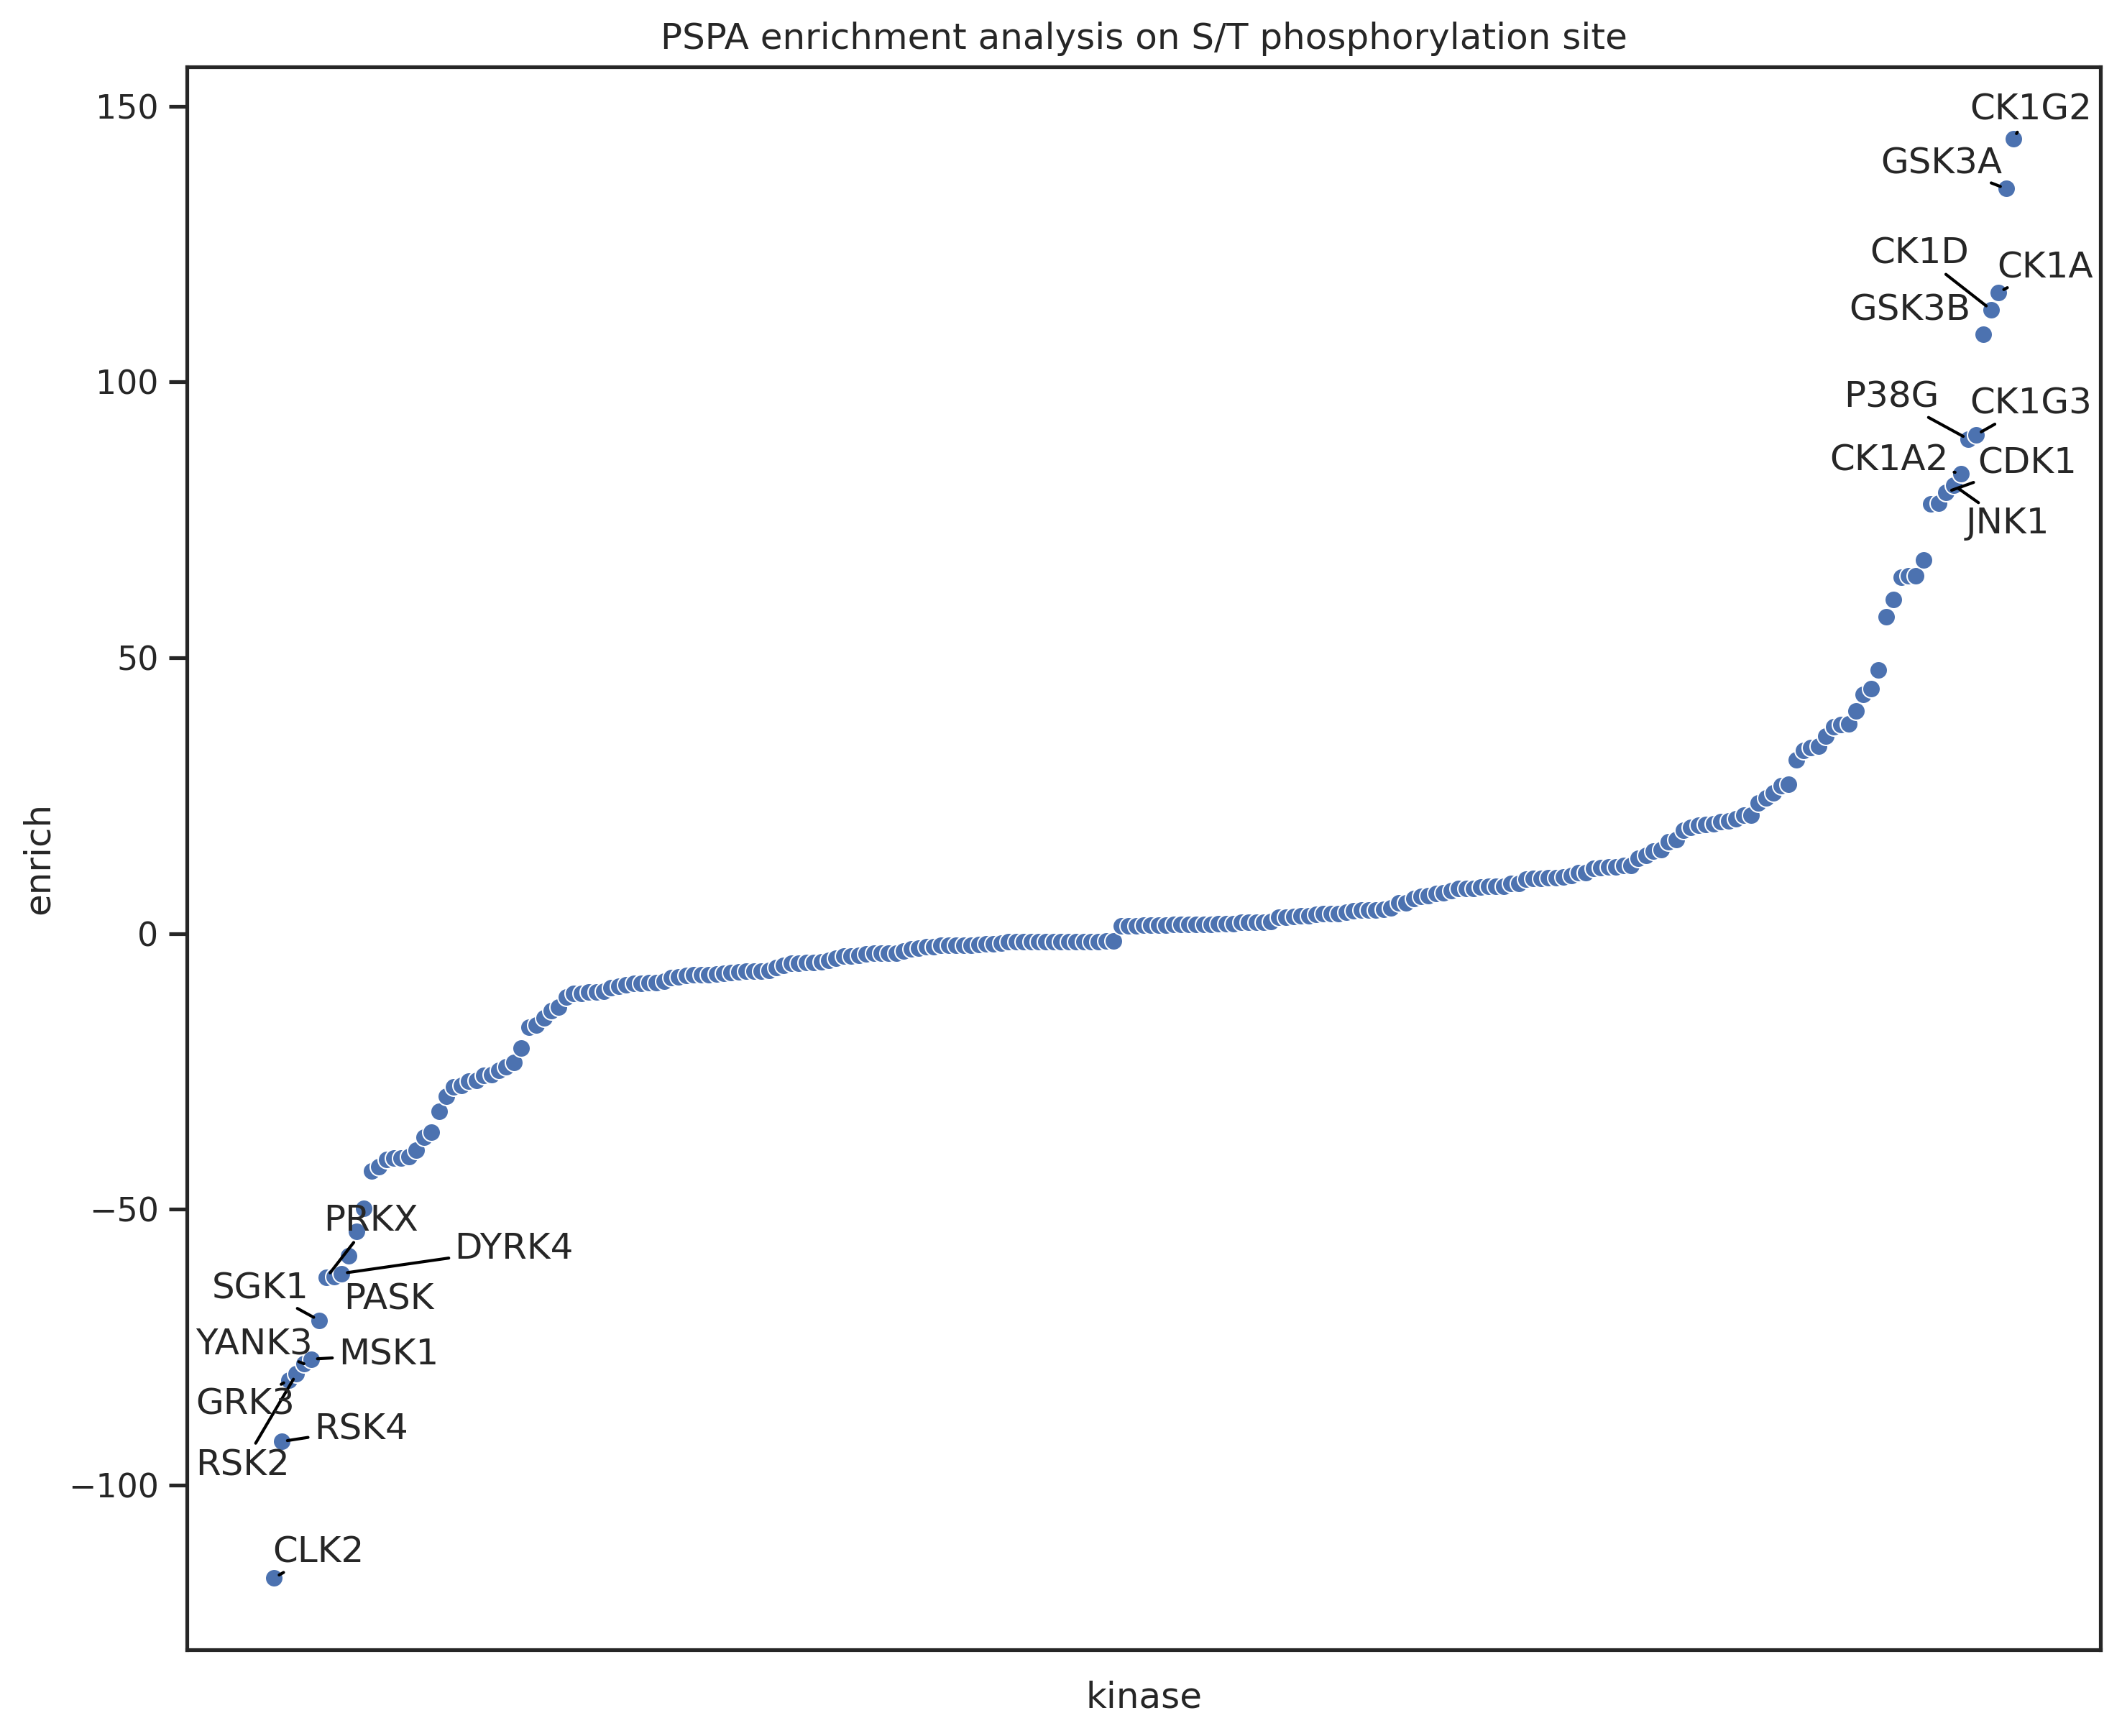

In [45]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

plot_rank(st_cddm.sort_values('enrich'),'kinase','enrich')
plt.title('CDDM enrichment analysis on S/T phosphorylation site');


plot_rank(st_pspa.sort_values('enrich'),'kinase','enrich')
plt.title('PSPA enrichment analysis on S/T phosphorylation site');

### Delta

"delta" is the difference between up_weighted_cnt and dn_weighted_cnt

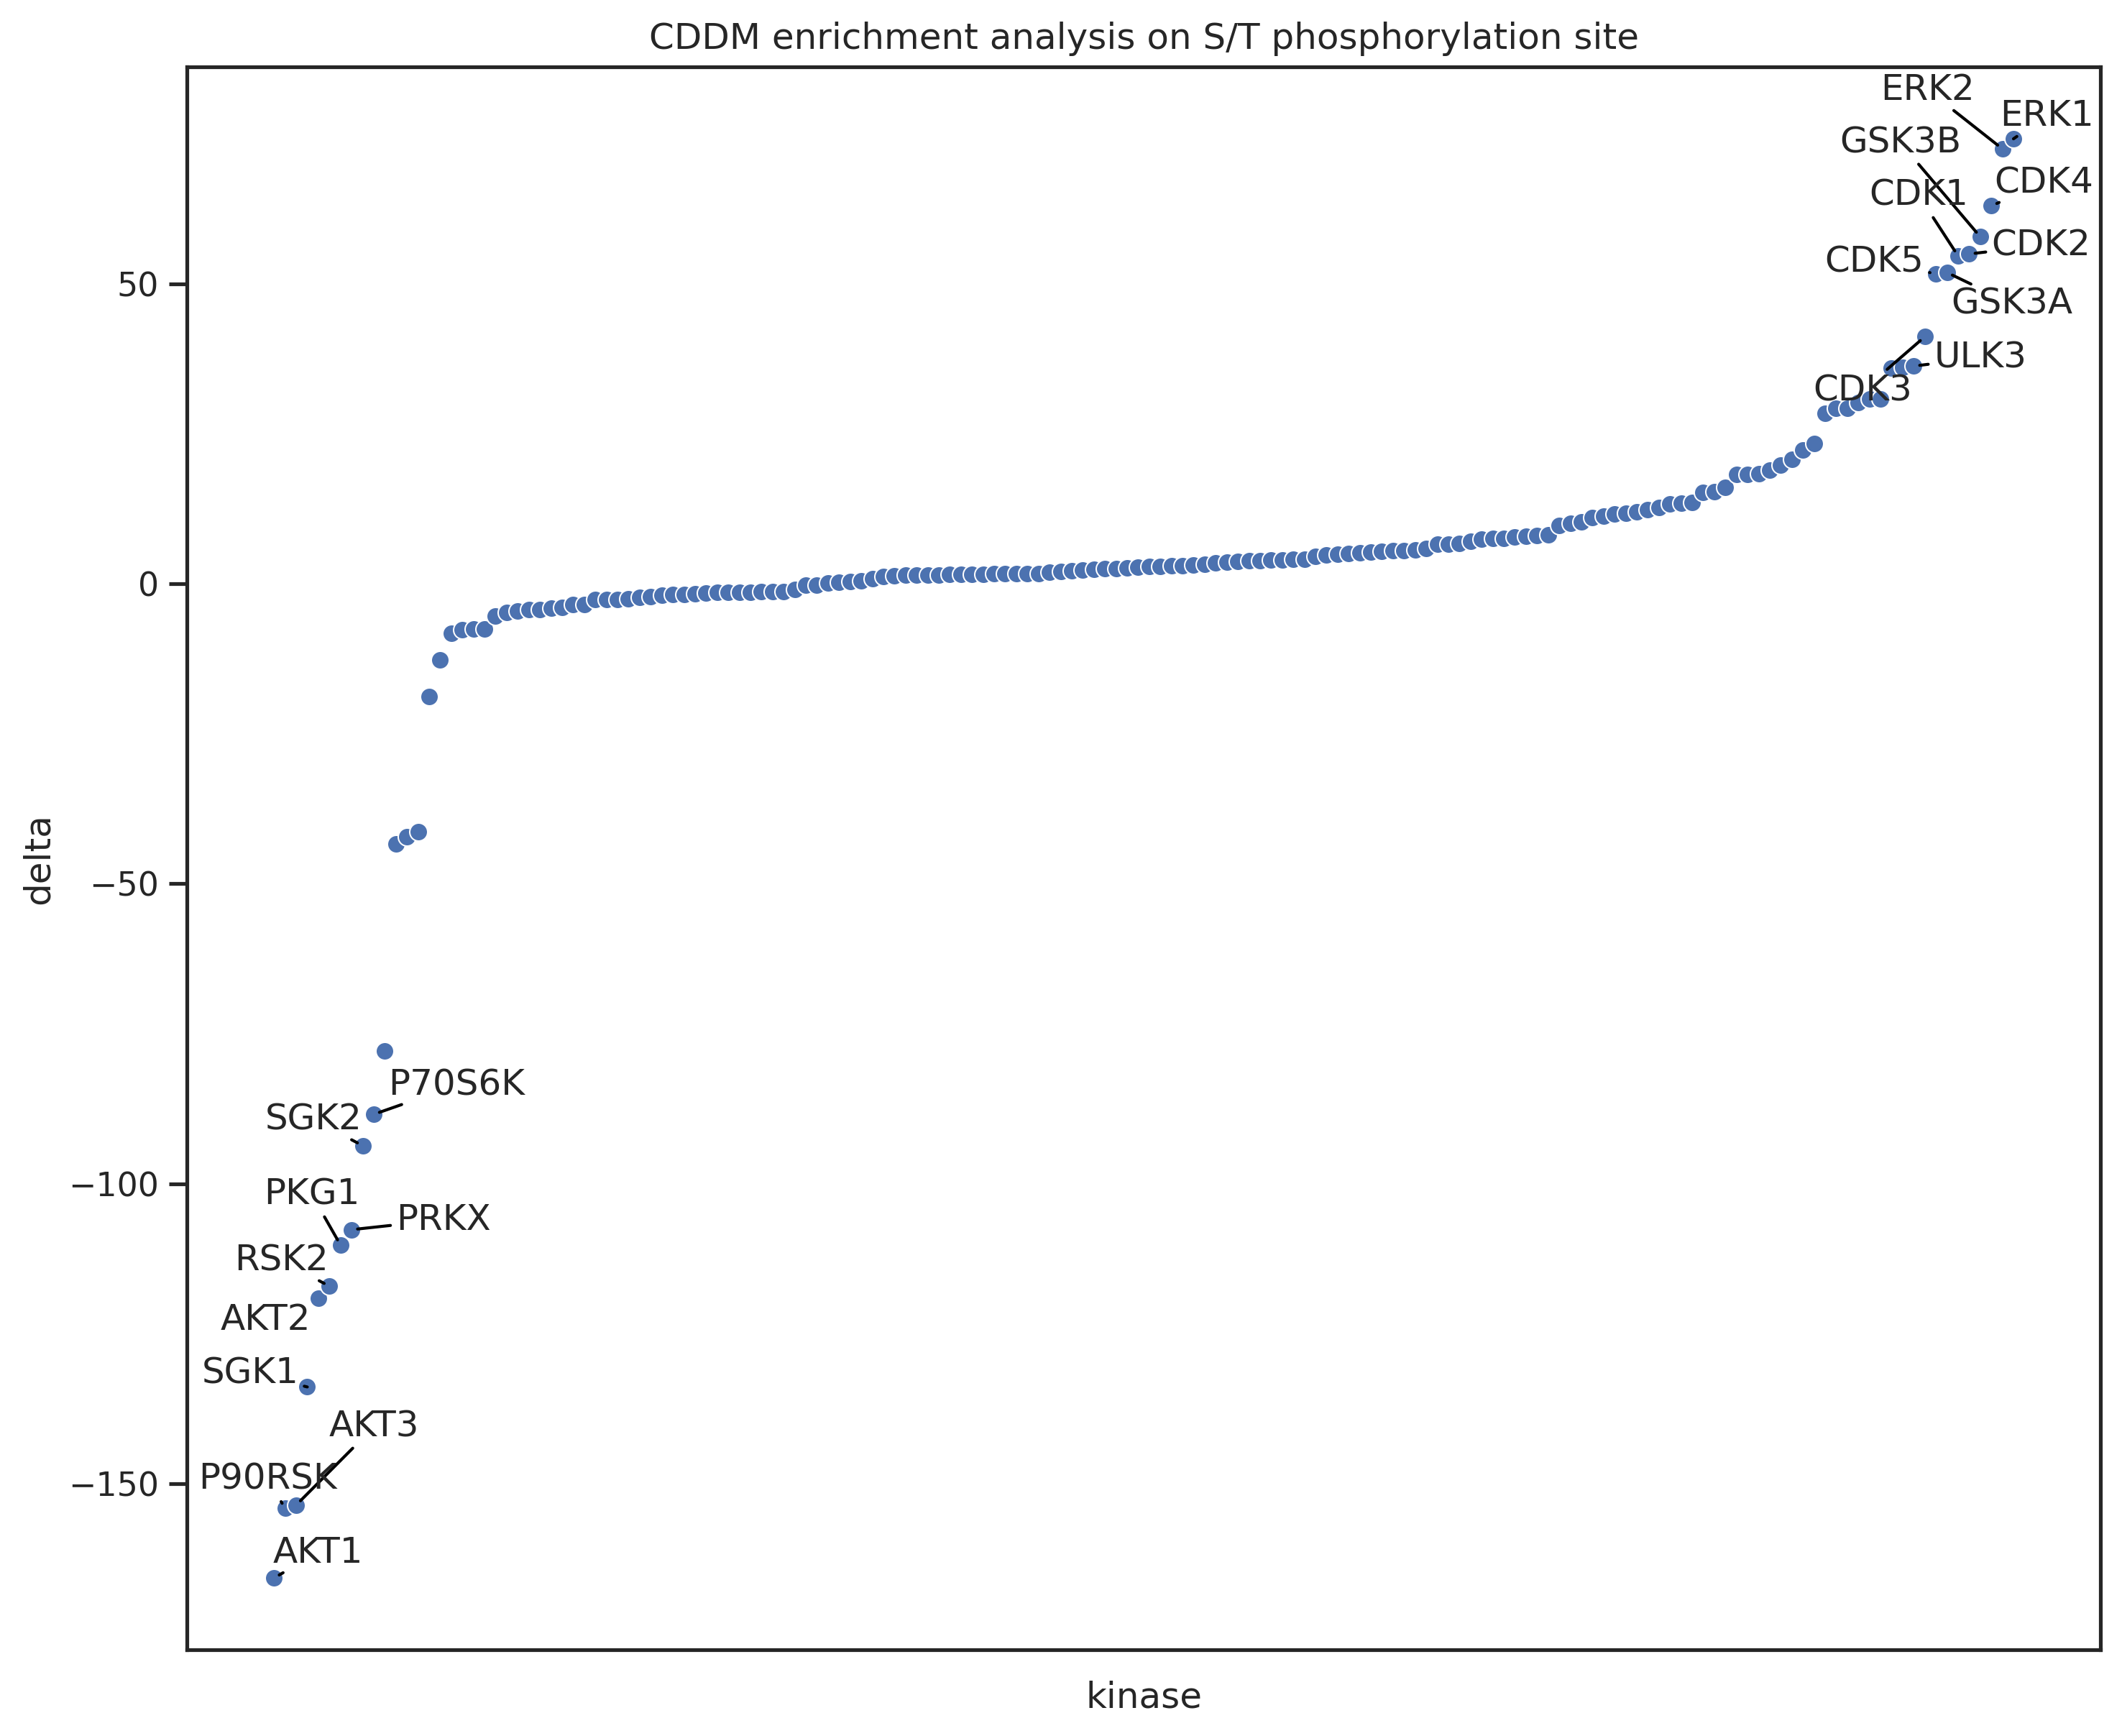

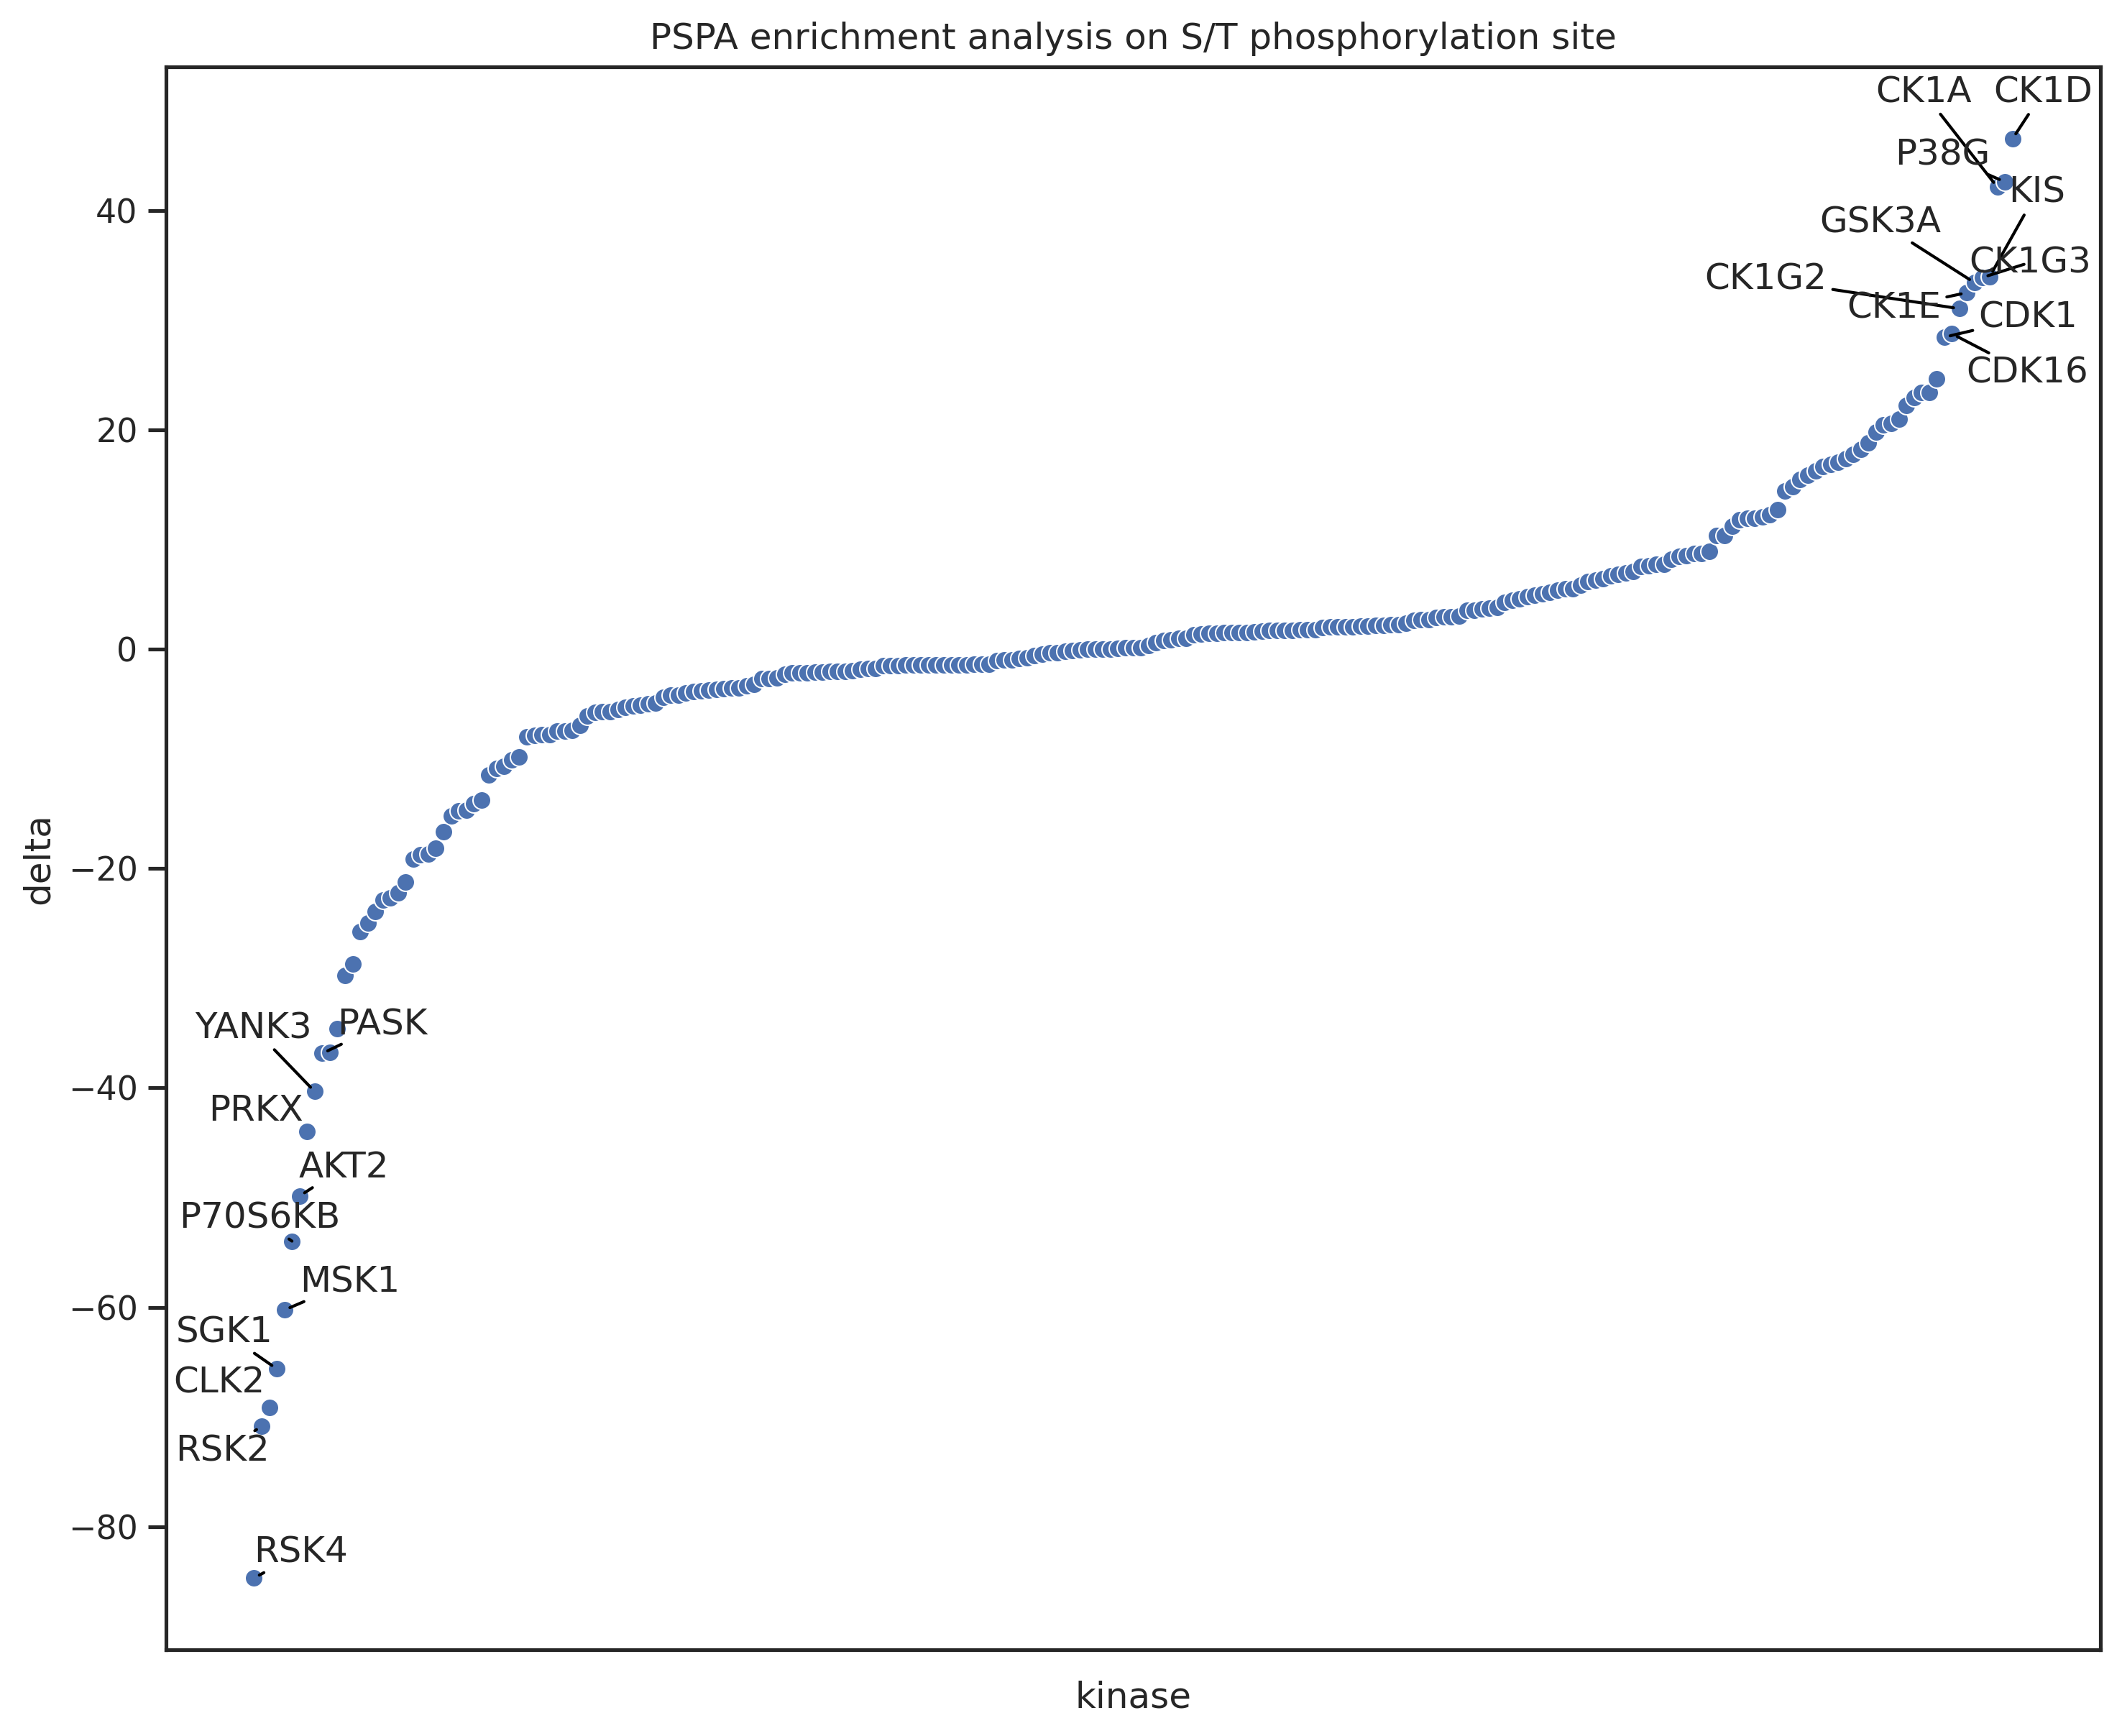

In [46]:
plot_rank(st_cddm.sort_values('delta'),'kinase','delta')
plt.title('CDDM enrichment analysis on S/T phosphorylation site');


plot_rank(st_pspa.sort_values('delta'),'kinase','delta')
plt.title('PSPA enrichment analysis on S/T phosphorylation site');

### Visualize in bar graph

In [47]:
def get_bar_data(df, score_col, top_n = 5):
    
    data = df.sort_values(score_col)[['kinase',score_col]]

    data.columns = ['Kinase','Score']
    
    data = pd.concat([data.head(top_n),data.tail(top_n)]).set_index('Kinase')
    
    return data

In [48]:
bar_cddm = get_bar_data(st_cddm,'delta')

bar_pspa = get_bar_data(st_pspa,'delta')

In [49]:
bar_cddm

,Score
Kinase,
AKT1,-165.747031584955010
P90RSK,-154.150772898813386
AKT3,-153.580866137689185
SGK1,-133.894470654112240
AKT2,-119.147437034164042
CDK2,54.970308485674906
GSK3B,57.836370620535668
CDK4,62.984207099749483
ERK2,72.493678198927299


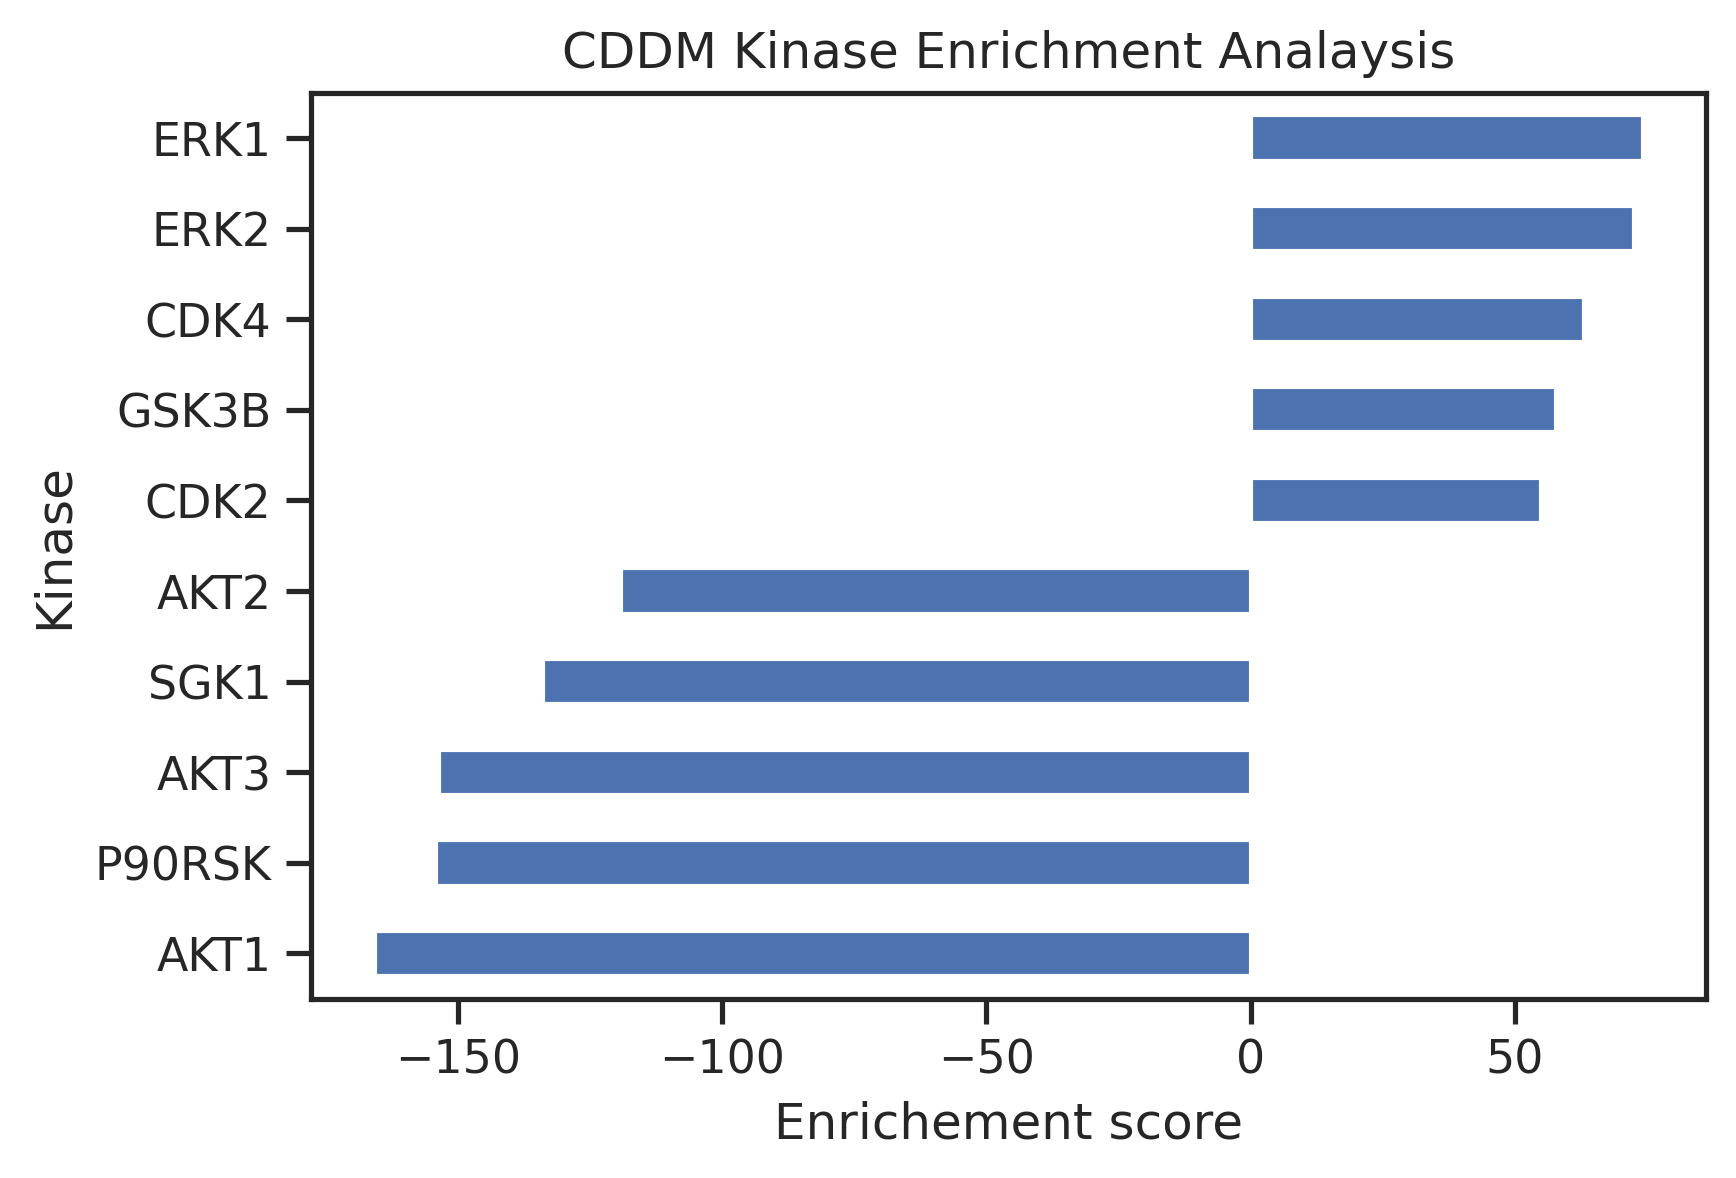

In [50]:
bar_cddm.plot.barh(legend=False)
plt.xlabel('Enrichement score')
plt.title('CDDM Kinase Enrichment Analaysis');

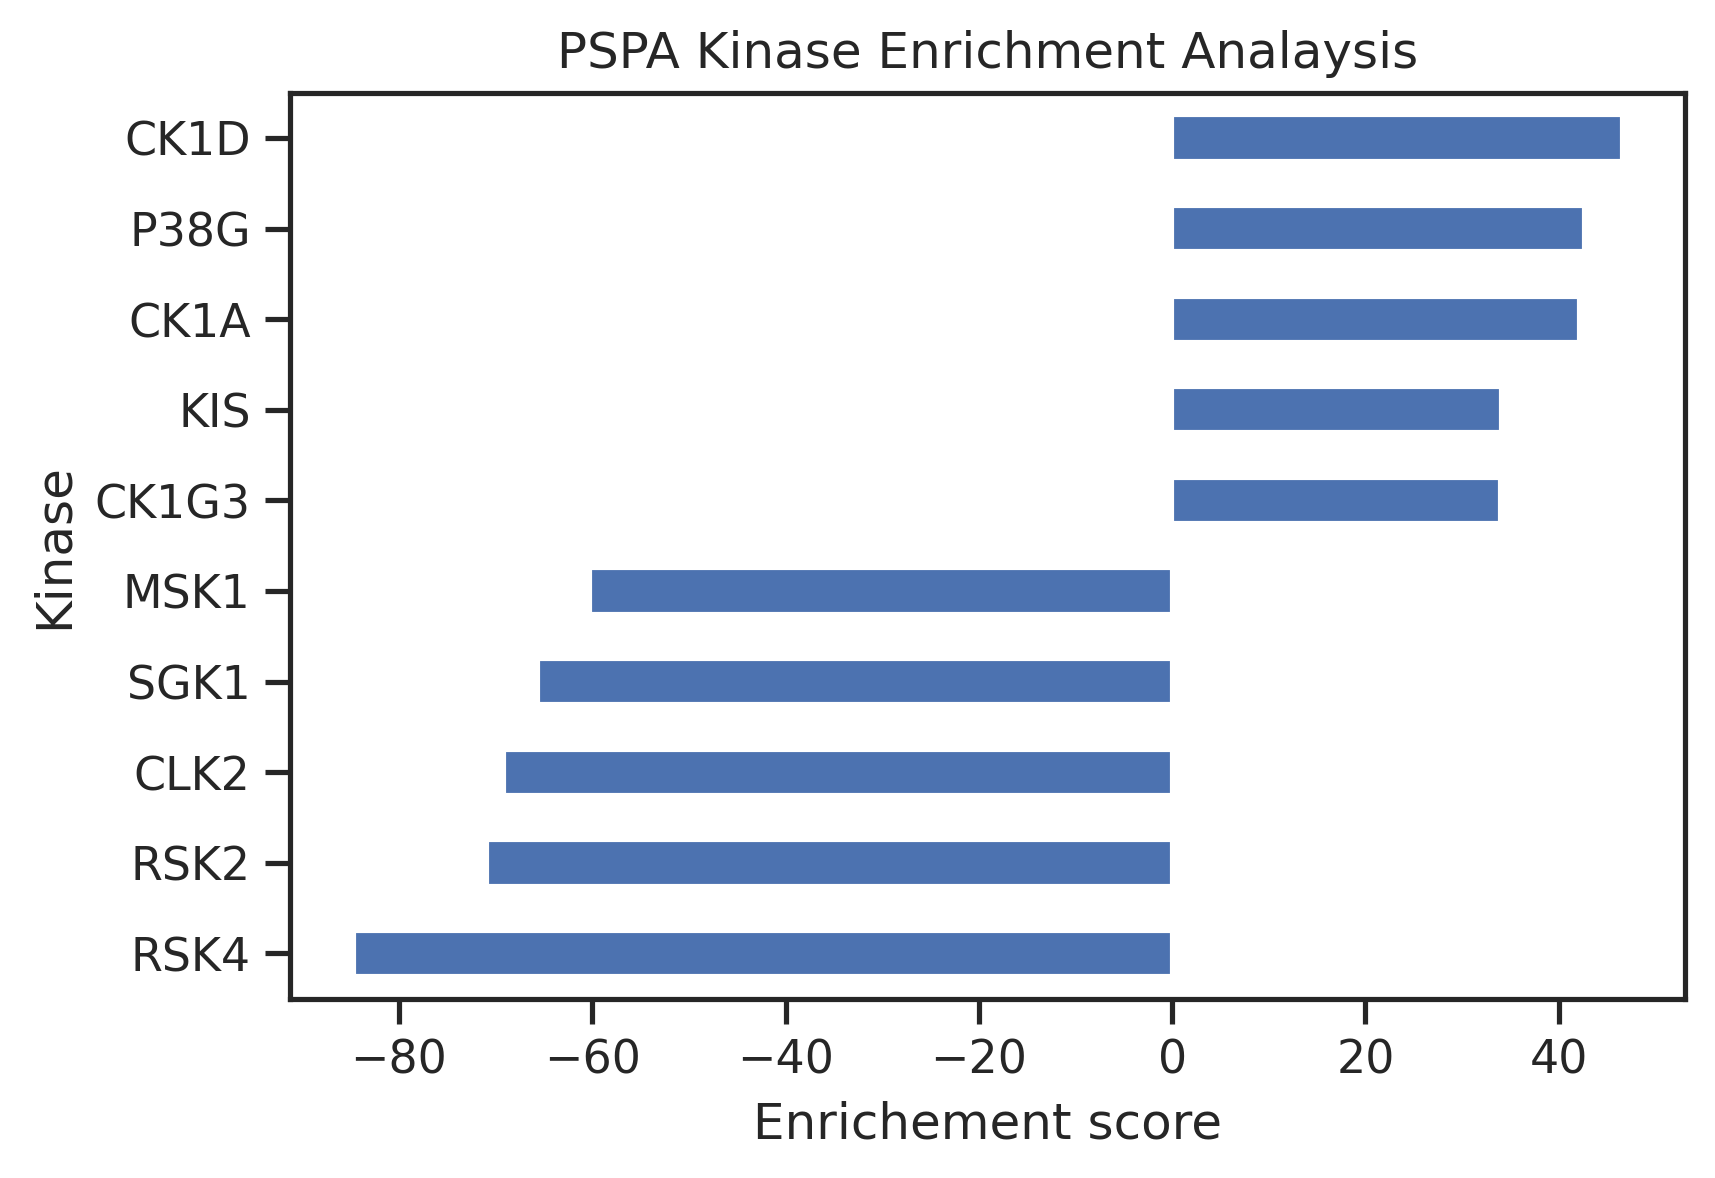

In [51]:
bar_pspa.plot.barh(legend=False)
plt.xlabel('Enrichement score')
plt.title('PSPA Kinase Enrichment Analaysis');

## Others, directly inspect important site and its protein

### Important site

Some gene site contains multiple gene name seperated by ";" we will explode them.

In [52]:
azd['gene'] = azd.gene_site.str.split('_').str[0].str.split(';')

In [53]:
azd.loc[1887]

gene_site                AGAP1_S422
site_seq            SACAPIssPKTNGLS
log2FC            0.147629999999999
p_value           0.028757878592464
p_adj             0.194862739901574
significant                   False
signed_logP       1.541243154087758
signed_logPadj    0.710271195269888
site_seq2           SACAPIssPKTNGLS
len                              15
acceptor                          s
gene                        [AGAP1]
Name: 1887, dtype: object

In [54]:
azd = azd.explode('gene')

In [55]:
sorted_site = azd.sort_values('signed_logPadj')[['gene_site','signed_logPadj']]

In [56]:
top_n = 10
sorted_site_top = pd.concat([sorted_site.head(top_n),sorted_site.tail(top_n)])

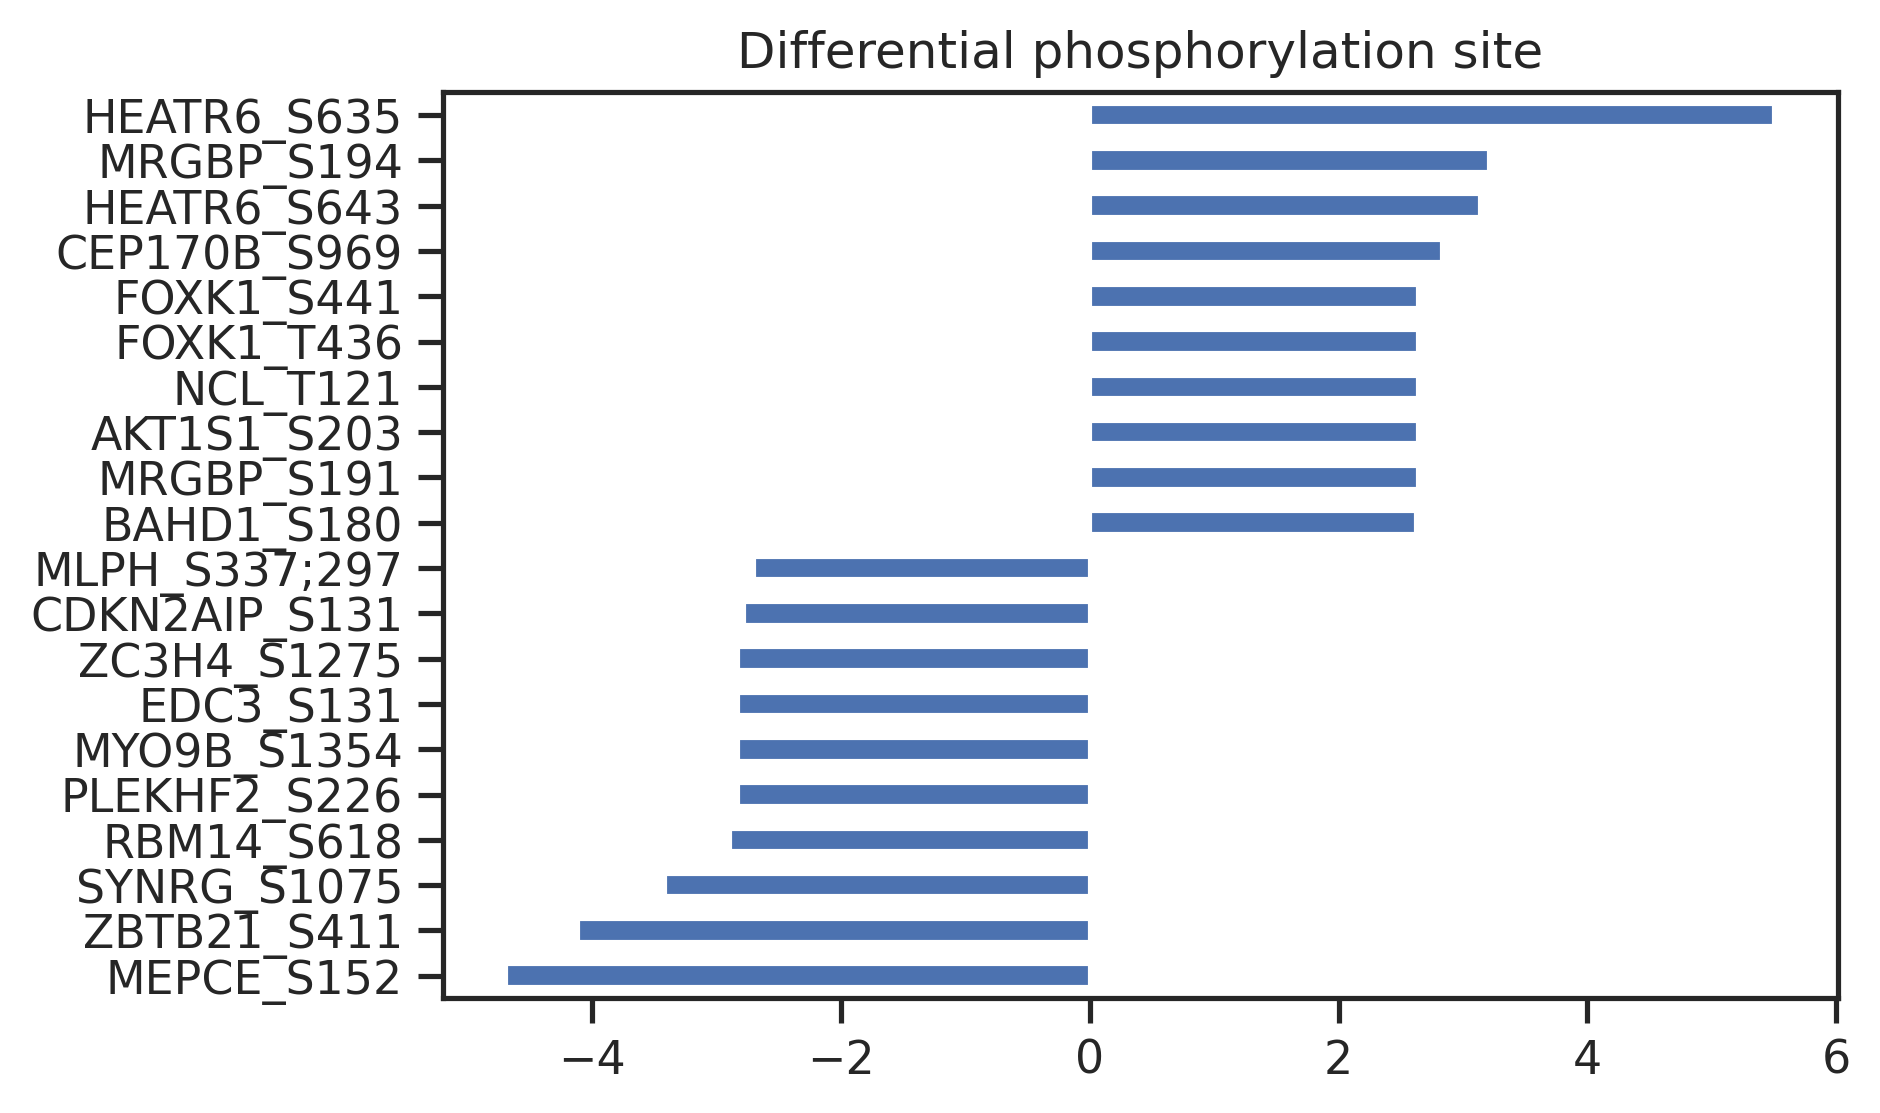

In [57]:
sorted_site_top.set_index('gene_site').plot.barh(legend=False)
plt.ylabel('')
plt.title('Differential phosphorylation site');

### Gene analysis

For each protein, it has multiple phosphorylation sites with different p value, we will take the most significant p value to represent that protein (gene)

In [58]:
def get_max(x):
    x = x.dropna().sort_values().values
    return x[0] if abs(x[0])>abs(x[-1]) else x[-1]

In [59]:
azd_gene = azd.groupby('gene').agg({'signed_logPadj':get_max,'gene_site':'count'}).reset_index()

In [60]:
sorted_gene = azd_gene.sort_values('signed_logPadj')

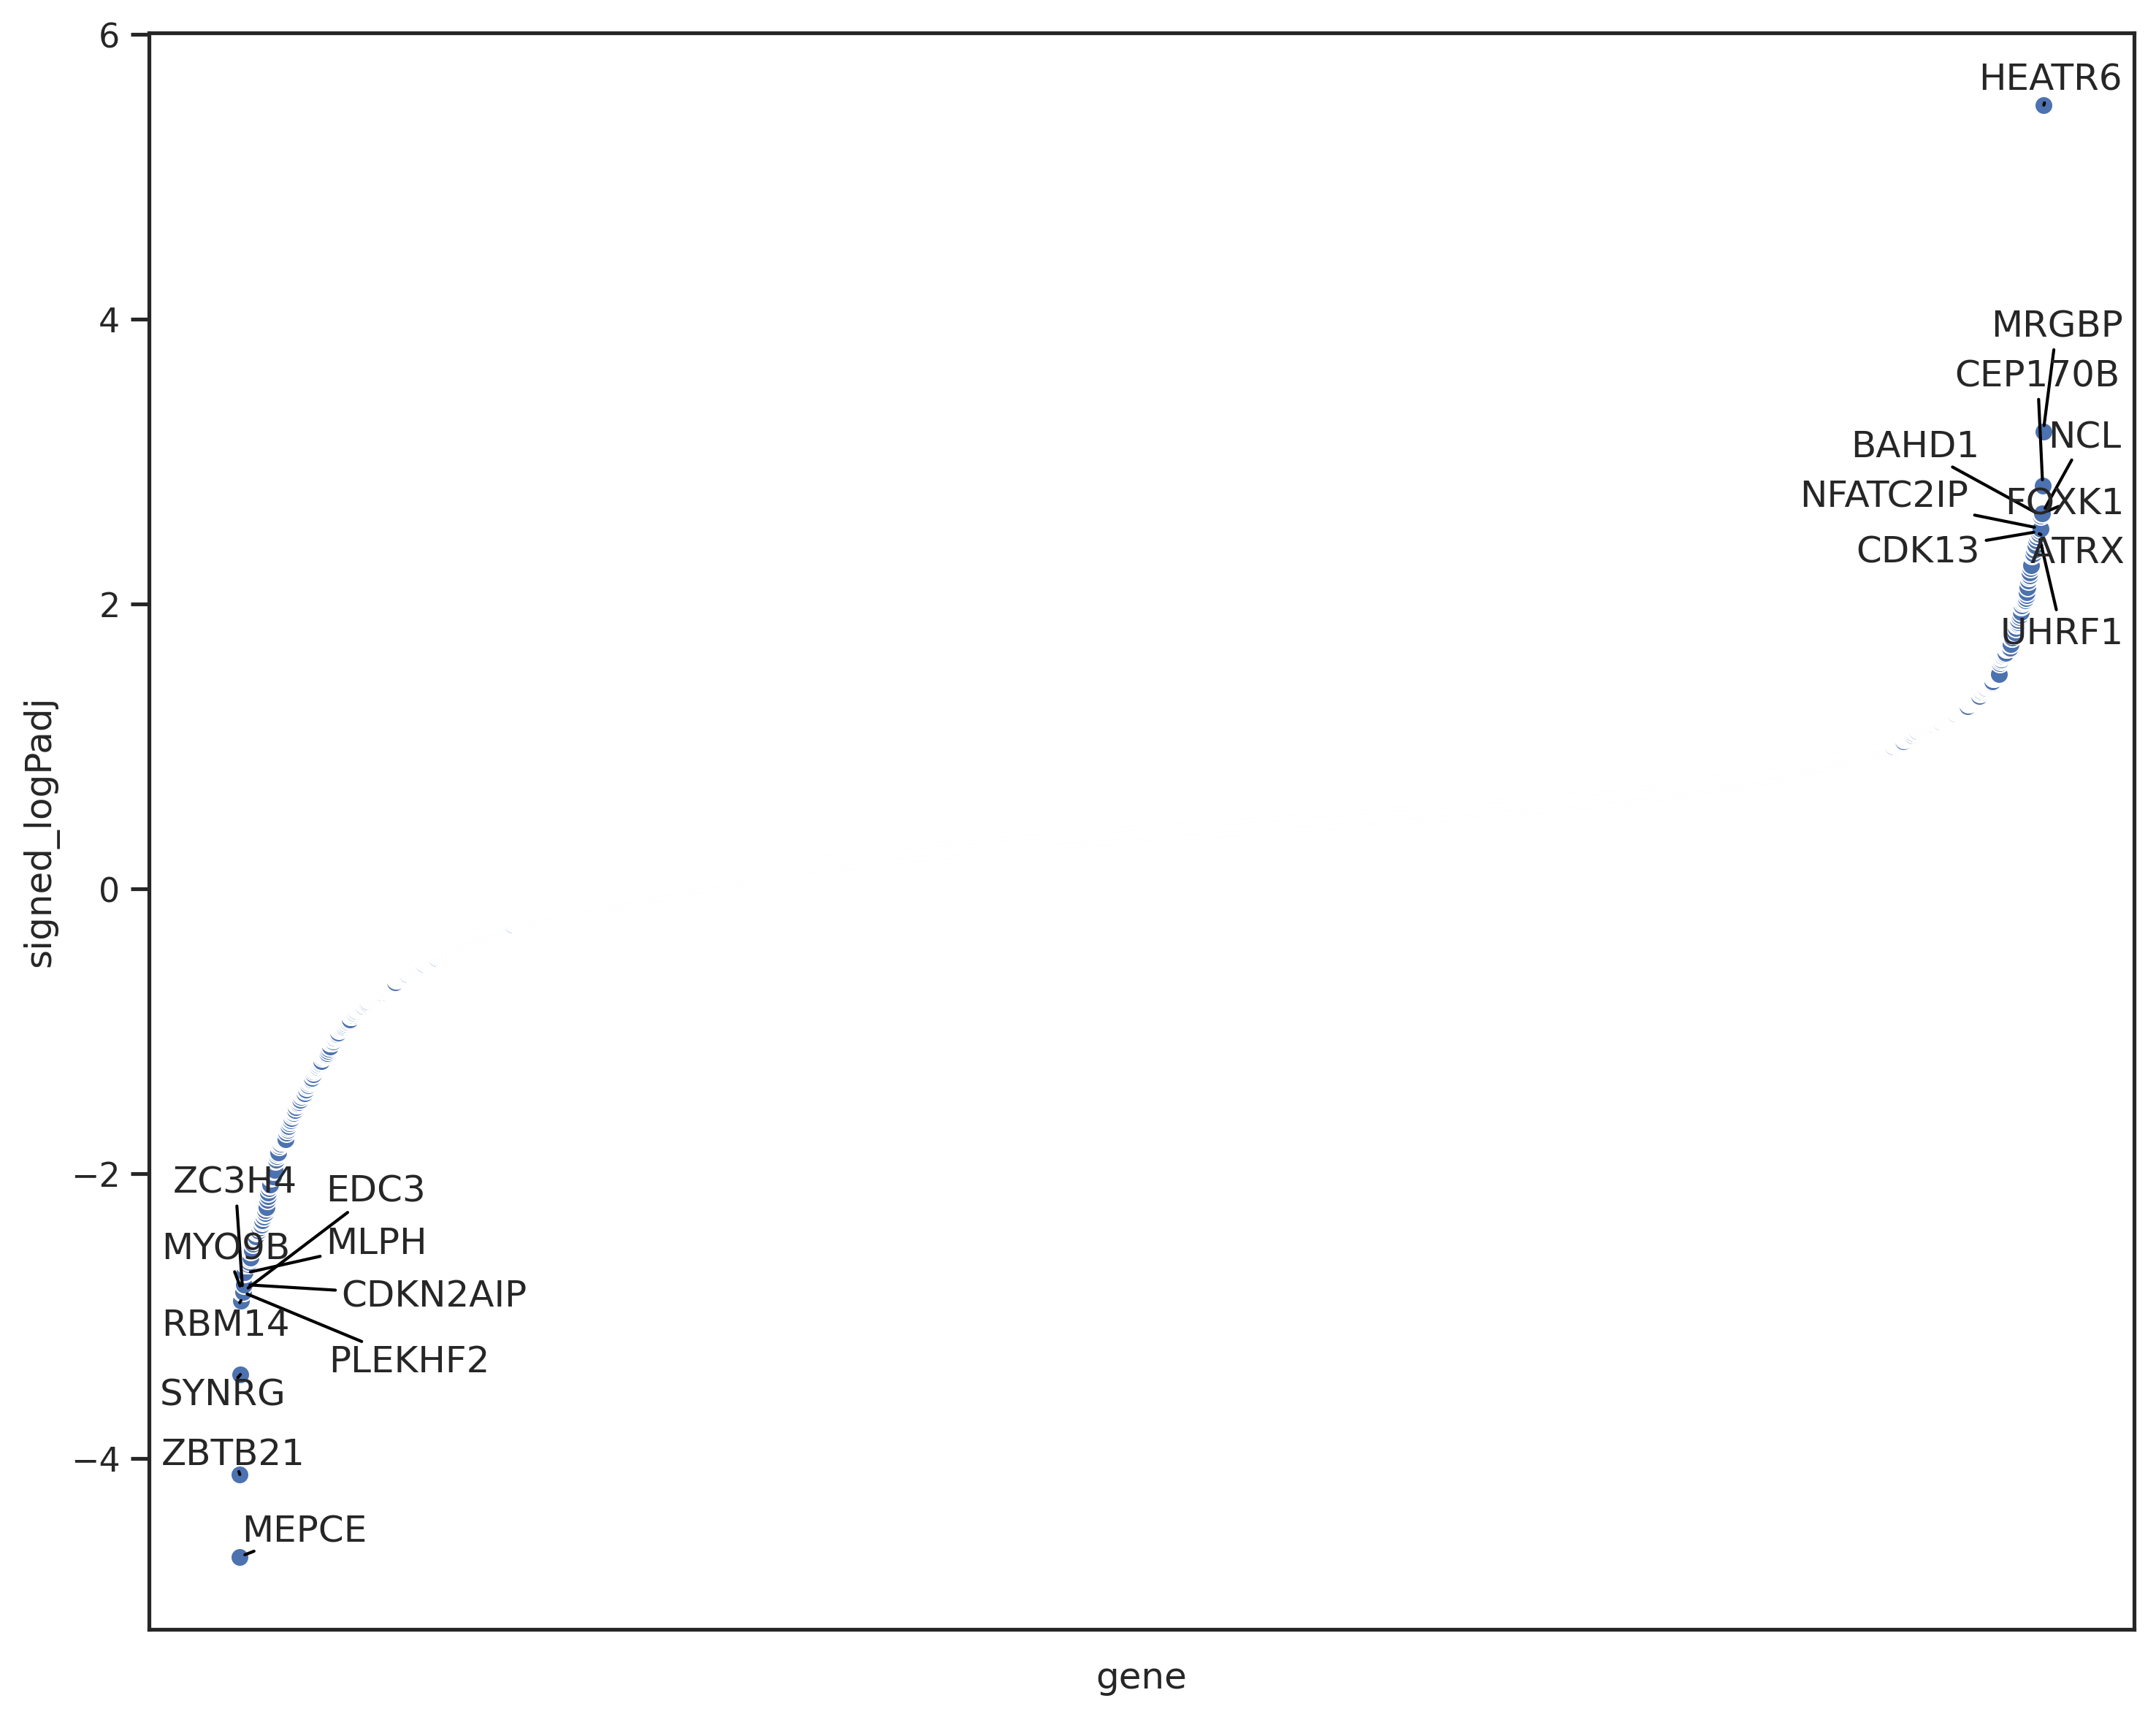

In [61]:
plot_rank(sorted_gene,x = 'gene',y='signed_logPadj')

### Kinase analysis

In [62]:
info = Data.get_kinase_info().rename(columns={'ID_HGNC':'gene'}).query('pseudo=="0"')

In [63]:
azd_kinase = azd_gene.merge(info)

In [64]:
sorted_kinase = azd_kinase.sort_values('signed_logPadj')

In [66]:
sorted_kinase

,gene,signed_logPadj,gene_site,kinase,ID_coral,uniprot,group,family,subfamily_coral,subfamily,in_ST_paper,in_Tyr_paper,in_cddm,pseudo,pspa_category_small,pspa_category_big,cddm_big,cddm_small,length,human_uniprot_sequence,kinasecom_domain,nucleus,cytosol,cytoskeleton,plasma membrane,mitochondrion,Golgi apparatus,endoplasmic reticulum,vesicle,centrosome,aggresome,main_location
151,ULK1,-2.443966805825115,9,ULK1,ULK1,O75385,Other,ULK,None,ULK,1,0,0,0,ULK/TTBK,ULK/TTBK,NaN,NaN,649,MEPGRGGTETVGKFEFSRKDLIGHGAFAVVFKGRHREKHDLEVAVKCINKKNLAKSQTLLGKEIKILKELKHENIVALYDFQEMANSVYLVMEYCNGGDLADYLHAMRTLSEDTIRLFLQQIAGAMRLLHSKGIIHRDLKPQNILLSNPAGRRANPNSIRVKIADFGFARYLQSNMMAATLCGSPMYMAPEVIMSQHYDGKADLWSIGTIVYQCLTGKAPFQASSPQDLRLFYEKNKTLVPTIPRETSAPLRQLLLALLQRNHKDRMDFDEFFHHPFLDASPSVRKSPPVPVPSYPSSGSGSSSSSSSTSHLASPPSLGEMQQLQKTLASPADTAGFLHSSRDSGGSKDSSCDTDDFVMVPAQFPGDLVAEAPSAKPPPDSLMCSGSSLVASAGLESHGRTPSPSPPCSSSPSPSGRAGPFSSSRCGASVPIPVPTQVQNYQRIERNLQSPTQFQTPRSSAIRRSGSTSPLGFARASPSPPAHAEHGGVLARKMSLGGGRPYTPSPQVGTIPERPGWSGTPSPQGAEMRGGRSPRPGSSAPEHSPRTSGLGCRLHSAPNLSDLHVVRPKLPKPPTDPLGAVFSPPQASPPQPSHGL...,FSRKDLIGHGAFAVVFKGRHREKHDLEVAVKCINKKNLAKSQTLLGKEIKILKELKHENIVALYDFQEMANSVYLVMEYCNGGDLADYLHAMRTLSEDTIRLFLQQIAGAMRLLHSKGIIHRDLKPQNILLSNPAGRRANPNSIRVKIADFGFARYLQSNMMAATLCGSPMYMAPEVIMSQHYDGKADLWSIGTIVYQCLTGKAPFQASSPQDLRLFYEKNKTLVPTIPRETSAPLRQLLLALLQRNHKDRMDFDEFFHHPFL,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,cytosol
122,RPS6KB1,-2.254639765747712,3,P70S6K,p70S6K,P23443,AGC,RSK,RSKp70,RSKp70,1,0,1,0,S6K/RSK,basophilic,4.0,30.0,421,MRRRRRRDGFYPAPDFRDREAEDMAGVFDIDLDQPEDAGSEDELEEGGQLNESMDHGGVGPYELGMEHCEKFEISETSVNRGPEKIRPECFELLRVLGKGGYGKVFQVRKVTGANTGKIFAMKVLKKAMIVRNAKDTAHTKAERNILEEVKHPFIVDLIYAFQTGGKLYLILEYLSGGELFMQLEREGIFMEDTACFYLAEISMALGHLHQKGIIYRDLKPENIMLNHQGHVKLTDFGLCKESIHDGTVTHTFCGTIEYMAPEILMRSGHNRAVDWWSLGALMYDMLTGAPPFTGENRKKTIDKILKCKLNLPPYLTQEARDLLKKLLKRNAASRLGAGPGDAGEVQAHPFFRHINWEELLARKVEPPFKPLLQSEEDVSQFDSKFTRQTPVDSPDDSTLSESANQVFLGFTYVAPSVLESVKEKFSFEPKIRSPRRFIGSPRTPVSPVKFSPGDFWGRGASASTANPQTPVEYPMETSGIEQMDVTMSGEASAPLPIRQPNSGPYKKQAFPMISKRPEHLRMNL,FELLRVLGKGGYGKVFQVRKVTGANTGKIFAMKVLKKAMIVRNAKDTAHTKAERNILEEVKHPFIVDLIYAFQTGGKLYLILEYLSGGELFMQLEREGIFMEDTACFYLAEISMALGHLHQKGIIYRDLKPENIMLNHQGHVKLTDFGLCKESIHDGTVTHTFCGTIEYMAPEILMRSGHNRAVDWWSLGALMYDMLTGAPPFTGENRKKTIDKILKCKLNLPPYLTQEARDLLKKLLKRNAASRLGAGPGDAGEVQAHPFF,4.0,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,nucleus
129,SRPK2,-2.235980650471455,8,SRPK2,SRPK2,P78362,CMGC,SRPK,None,SRPK,1,0,0,0,SRPK/CLK,pro-directed,NaN,NaN,688,MSVNSEKSSSSERPEPQQKAPLVPPPPPPPPPPPPPLPDPTPPEPEEEILGSDDEEQEDPADYCKGGYHPVKIGDLFNGRYHVIRKLGWGHFSTVWLCWDMQGKRFVAMKVVKSAQHYTETALDEIKLLKCVRESDPSDPNKDMVVQLIDDFKISGMNGIHVCMVFEVLGHHLLKWIIKSNYQGLPVRCVKSIIRQVLQGLDYLHSKCKIIHTDIKPENILMCVDDAYVRRMAAEATEWQKAGAPPPSGSAVSTAPQQKPIGKISKNKKKKLKKKQKRQAELLEKRLQEIEELEREAERKIIEENITSAAPSNDQDGEYCPEVKLKTTGLEEAAEAETAKDNGEAEDQEEKEDAEKENIEKDEDDVDQELANIDPTWIESPKTNGHIENGPFSLEQQLDDEDDDEEDCPNPEEYNLDEPNAESDYTYSSSYEQFNGELPNGRHKIPESQFPEFSTSLFSGSLEPVACGSVLSEGSPLTEQEESSPSHDRSRTVSASSTGDLPKAKTRAADLLVNPLDPRNADKIRVKIADLGNACWVHKHFTEDIQTRQYRSIEVLIGAGYSTPADIWSTACMAFELATGDYLFEPHSGEDYSRDE...,YHVIRKLGWGHFSTVWLCWDMQGKRFVAMKVVKSAQHYTETALDEIKLLKCVRESDPSDPNKDMVVQLIDDFKISGMNGIHVCMVFEVLGHHLLKWIIKSNYQGLPVRCVKSIIRQVLQGLDYLHSKCKIIHTDIKPENILMCVDDAYVRRMAAEATEWQKAGAPPPSGSAVSTAPQQKPIGKISKNKKKKLKKKQKRQAELLEKRLQEIEELEREAERKIIEENITSAAPSNDQDGEYCPEVKLKTTGLEEAAEAETAKDNGEAEDQEEKEDAEKENIEKDEDDVDQELANIDPTWIESPKTNGHIENGPFSLEQQLDDEDDDEEDCPNPEEYNLDEPNAESDYTYSSSYEQFNGELPNGRHKIPESQFPEFSTSLFSGSLEPVACGSVLSEGSPLTEQEESSPSHDRSRTVSASSTGDLPKAKTRAADLLVNPLDPRNADKIRVKIADLGNACWVHKHFTEDIQTRQYRSIEVLIGAGYSTPADIWSTACMAFELATGDYLFEPHSGEDYSRDEDHIAHIIELLGSIPRHFALSGKYSREFFNRRGELRHITKLKPWSLFDVLVEKYGWPHEDAAQFTDFLIPMLEMVPEKRAS...,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
34,CHEK1,-2.019035597151841,2,CHK1,CHK1,O14757,CAMK,CAMKL,CHK1,CHK1,1,0,1,0,PRKD/MAPKAPK,basophilic,4.0,38.0,476,MAVPFVEDWDLVQTLGEGAYGEVQLAVNRVTEEAVAVKIVDMKRAVDCPENIKKEICINKMLNHENVVKFYGHRREGNIQYLFLEYCSGGELFDRIEPDIGMPEPDAQRFFHQLMAGVVYLHGIGITHRDIKPENLLLDERDNLKISDFGLATVFRYNNRERLLNKMCGTLPYVAPEL

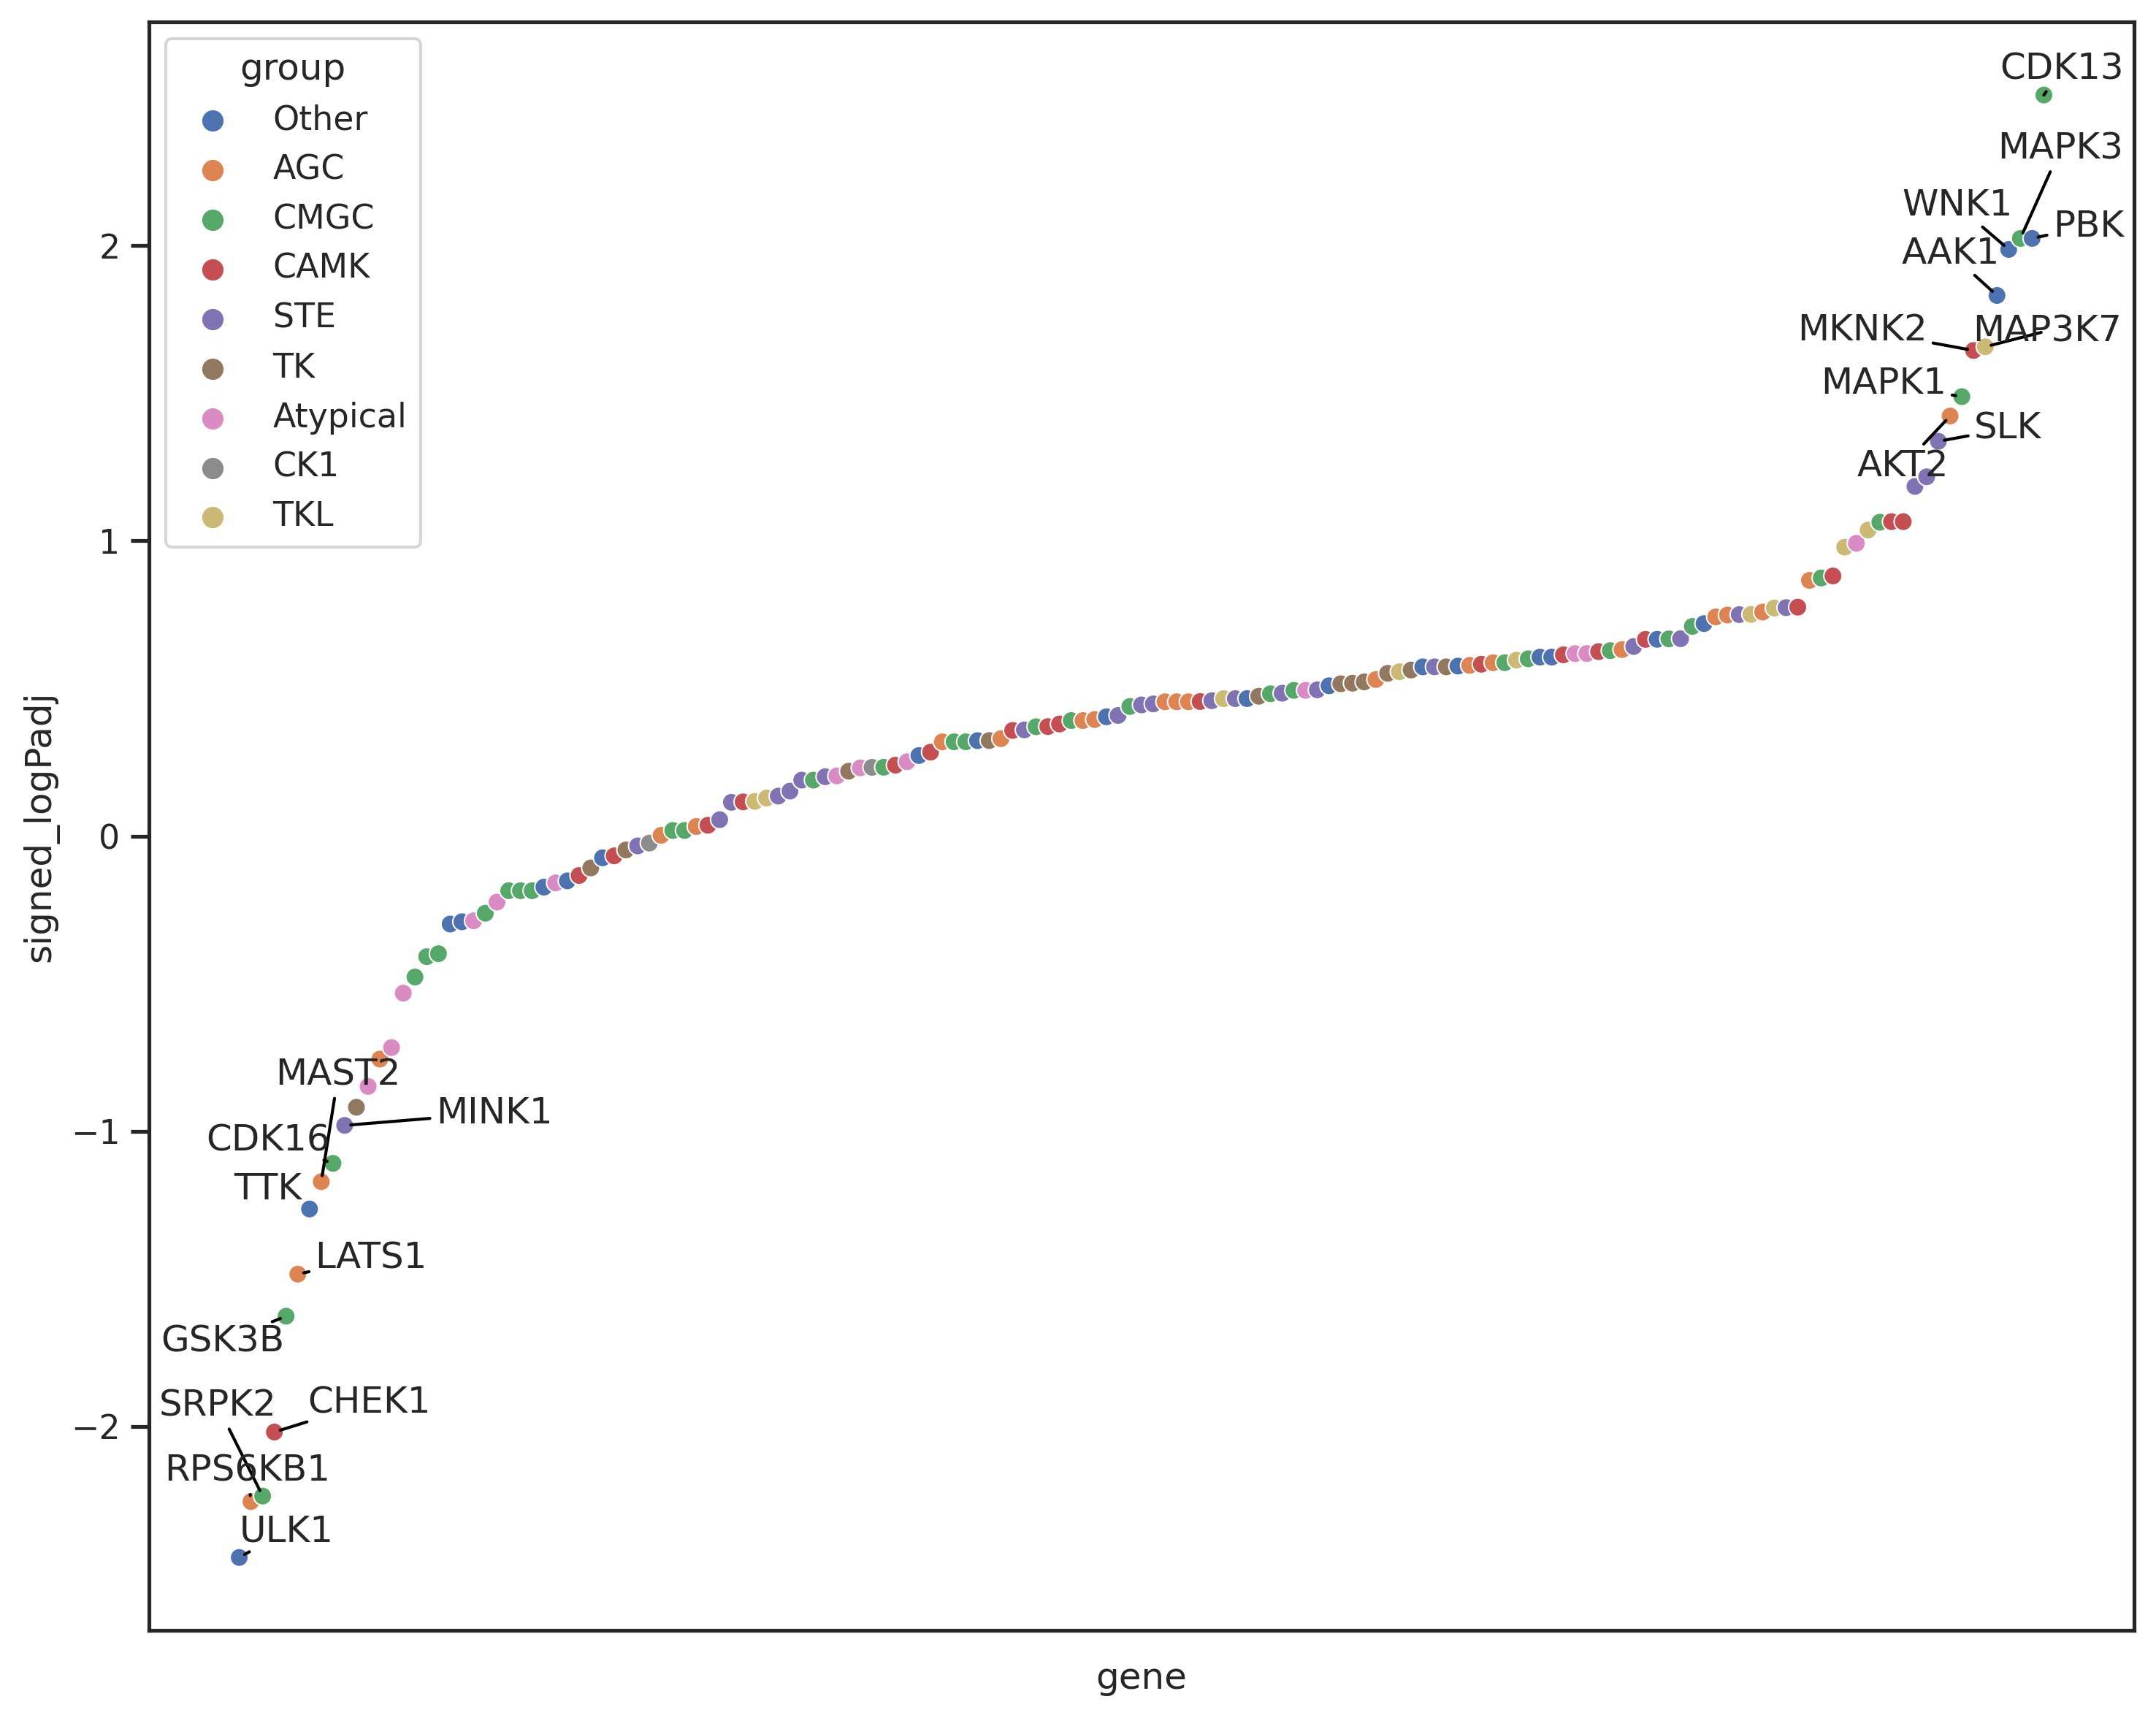

In [67]:
plot_rank(sorted_kinase,x = 'gene',y='signed_logPadj',hue='group')